<a href="https://colab.research.google.com/github/tollycollins/MathsQuestionGenerator/blob/main/MathsQuestionGeneratorCoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=False)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from typing import Optional
import random
import math
from itertools import islice
import os
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import IterableDataset, Dataset, DataLoader
from torch.nn.utils import weight_norm
from torch.nn.functional import softmax


# Data

In [ ]:
# 'Dataset' class which serves up a questions of the desired type
# https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd
# https://stackoverflow.com/questions/69778356/iterable-pytorch-dataset-with-multiple-workers


class Teacher(IterableDataset):
  """
  Generative dataset for question-method pairs.  

  Performs syntax and method checking of generated questions.  
  """
  # identifier for unknown questions
  UNKNOWN = 'unknown'


  def __init__(self, 
               batch_size=1024,
               q_size=16, 
               allow_blanks=False, 
               starting_confidence=0.1):
    """
    Parameters:
      batch_size: Size of a training batch.  Must match the size given to teh DataLoader.  
      q_size: Length of a question character sequence.  
      allow_blanks: If True, questions will not be penalised if they contain blank characters 
                    between the first and last mathematical characters.  
                    If False, all blank characters must be at the end of the sequence.  
      starting_confidence: controls the range of allowed integers for questin generation
    """

    self.batch_size = batch_size
    self.dataset_size = batch_size

    # question symbol vocabulary
    """
    Key: Type of symbol
    Value: character in the vocabulary
    """
    self.vocab = {
        'digits': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
        'operations': ['+', '-', '*'],
        'blank': ['_']
    }

    # for converting characters to indices for embedding, and converting back
    self.symbol_to_ix = self.get_vocab_lookup()
    self.ix_to_symbol = {v: k for k, v in self.symbol_to_ix.items()}

    # dictionary of available methods
    """
    Key: Method index
    Value: Method descriptor
    """
    self.methods = {
        0: 'I just know it',
        1: 'add 1',
        2: 'add a power of 10',
        3: 'subtract 1',
        4: 'subtract a power of 10',
        5: 'add / subtract any number',
        6: 'multiply by adding',
        7: 'multiply by a power of 10'
    }

    # untrained confidence level for a question
    self.starting_confidence = starting_confidence

    # question types
    """
    Key: Question type
    Value: list[tuple(syntax, possible starting methods, difficulty/confidence level)]
    """
    self.q_types = {
        'addition':         [('n+1',   [0, 1, 2],     starting_confidence), 
                             ('n+t',   [0, 2],        starting_confidence), 
                             ('n+n',   [0, 1, 2, 5],  starting_confidence), 
                             ('n+n+n', [0, 1, 2, 5],  starting_confidence)],
        'subtraction':      [('n-1',   [0, 3],        starting_confidence),
                             ('n-t',   [0, 4],        starting_confidence),
                             ('n-n',   [0, 3, 4, 5],  starting_confidence), 
                             ('n-n-n', [0, 3, 4, 5],  starting_confidence)], 
        'multiplication':   [('n*t',   [7, 6],        starting_confidence), 
                             ('n*n',   [6],           starting_confidence), 
                             ('n*n*n', [6],           starting_confidence)], 
        'mixed arithmetic': [('n+n-1', [0, 2, 3, 5],  starting_confidence), 
                             ('n+n-n', [0, 2, 5],     starting_confidence), 
                             ('n-n+n', [0, 2, 5],     starting_confidence)]
    }

    # allows specific types of questions to be requested
    # should be in the form tuple(q_type: str, subtype: Optional[str], methods: Optional[list[int]])
    self.question_requests = []

    # uniform length of question sequences
    self.q_size = q_size

    # allow blank characters inside question
    self.allow_blanks = allow_blanks

    # number ranges for question generation
    self.integer_range = (0, 10000)

    # identifier for unknown question types
    self.unknown = 'unknown'


  @property
  def vocab_size(self):
    vocab_len = 0
    for val in self.vocab.values():
      vocab_len += len(val)
    return vocab_len
  

  @property
  def methods_size(self):
    return len(self.methods)


  def serve(self, q_type: str, 
            subtype: Optional[str] = None):
    """
    Creates a single question-methods pair.

    Returns:
      Question_type: (type, subtype)
      Question: a sequence of characters of length self.q_size.  
      Method: Integers representing suggested methods to begin answering the question.
        [see self.methods]

    Parameters: 
      q_type: Question type: must be a key from self.q_types
      subtype: Integer index of list, which is the value of self.q_types[q_type] 

    If the question created is shorter than the sequence, the remaining space 
      will be padded with 'blank' characters.  
    """
    # pick a question
    if subtype:
      # try:
      found = False
      for v in self.q_types.values():
        for tupl in v:
          if tupl[0] == subtype:
            qu = tupl
            found = True
            break
        if found: 
          break
      if not found:
        raise RuntimeError(f"Subtype {subtype} not found")
      # except IndexError:
      #   print(f'Index {subtype} is out of range for question type {q_type}')
      #   pass
    elif q_type is not None:
      qu = random.choice(self.q_types[q_type])
    else: 
      q_type = random.choice(list(self.q_types.keys()))
      qu = random.choice(self.q_types[q_type])

    # get string representing question syntax
    q_string = qu[0]
    
    # parse syntax
    question = []
    # suggested_method = None
    break_flag = False
    for ch in q_string:
      if break_flag:
        break
      # numbers
      max_num = 0
      if ch == 'n':
        # maximum allowed number
        max_value = self.integer_range[1] * qu[2]
        # generate a number
        num = random.randint(0, max_value)
        # apply linear distribution for number of digits (to prevent skew towards higher digit numbers)
        num_digits = random.randint(1, int(math.log10(max_value)) + 2)
        num = num % (10 ** num_digits)
        # convert to string
        entry = str(num)
        max_num = max(max_num, num)
      elif ch == 't':
        # get a power of 10 less than the current largest number in the question
        entry = str(10 ** random.randint(1, max(1, int(math.log10(max_num + 1)))))
      else:
        entry = ch

      # add to question
      for ch in entry:
        question.append(ch)
        # check if the question is within the permitted length limit
        if len(question) > self.q_size:
          break_flag = True
          # if it is too long, generate a new question
          question_type, question, methods = self.serve(q_type, subtype)
          break
      
    # add empty padding
    for i in range(self.q_size - len(question)):
      question.append(self.vocab['blank'][0])

    methods = qu[1]
    question_type = (q_type, q_string)

    return question_type, question, methods
  

  def get_example(self):
    """
    Get a question from self.serve().  
    """
    # consider requests or generate random question if there are no requests
    for i in range(self.dataset_size):
      try:
        q_type = self.question_requests.pop()
      except IndexError:
        q_type = [random.choice(list(self.q_types))]
      
      if q_type == None:
        q_type = [random.choice(list(self.q_types))]

      # generate question
      question_type, original, meth = self.serve(*q_type)

      # get method targets
      methods = torch.zeros(self.methods_size)
      for i in meth:
        methods[i] = 1

      # convert to tensors
      question = []
      for ch in original:
        question.append(self.symbol_to_ix[ch])
      
      yield question_type, original, torch.tensor(question), methods

  
  def __iter__(self):
    """
    Create an iterator to be passed to the Dataloader.  
    The iterator created will be the same length as the batch size (self.batch_size).  
    """

    examples = self.get_example()

    # # add multiworker functionality
    # worker_total_num = torch.utils.data.get_worker_info().num_workers
    # worker_id = torch.utils.data.get_worker_info().id

    # data = islice(examples, worker_id, None, worker_total_num)

    return examples
  

  def get_dataLoader(self, batch_size=None, num_workers=1):
    if batch_size:
      self.batch_size = batch_size
    return DataLoader(self, batch_size=self.batch_size, num_workers=num_workers, pin_memory=True)


  def check(self, expr):
    """
    Syntax checker for generated questions.  
    """
    # strip blank characters at ends
    expr = expr.strip(self.vocab['blank'][0])

    # remove intermediate blank characters
    if self.allow_blanks:
      expr = expr.replace(self.vocab['blank'][0], '')
    
    # check it is not just a number
    if expr.isdigit():
      return False

    # don't allow prevailing '+'
    try:
      if expr[0] == '+':
        return False
    except IndexError:
      return False

    # don't allow some multiple operators
    disallowed = ['**', '*+', '++', '---', '-+']
    for d in disallowed:
      if d in expr:
        return False
    
    # if it is arithmetic
    try:
      eval(expr)
      return True
    except SyntaxError:
      return False
    except TypeError:
      return False
    except NameError:
      return False
    # don't allow impossible questions
    except ZeroDivisionError:
      return False


  def get_vocab_lookup(self):
    """
    Generate dictionary for index of character in vocabulary.  
    """
    # get vocab list
    vocab = []
    for li in self.vocab.values():
      vocab += li
    # create lookup dictionary
    return {symbol: i for i, symbol in enumerate(vocab)}


  def question_from_ix(self, question):
    """
    Get the vocabulary character that corresponds to a given index.  
    """
    # convert from a tensor
    if type(question) == torch.Tensor:
      question = torch.squeeze(question)
      question.tolist()

    # change to a human-readable string
    new_q = ''
    for index in question:
      ch = self.ix_to_symbol[int(index)]
      new_q += ch if ch != self.vocab['blank'][0] else ''

    return new_q
  

  def question_from_model(self, output):
    """
    Get question from model output.  
    Model output is sequence of vectors representing confidence for each symbol.  
    Select the symbol with the highest confidence in each case.  

    Parameters:
      output (Tensor): A batch of model outputs (B x C x L)
    """
    # Find integer corresponding with channel with highest value for each sequence position
    output = torch.argmax(output, dim=1)

    # convert to symbols
    symbol_questions = []
    for row in output[:]:
      symbol_questions.append(self.question_from_ix(row))

    return symbol_questions
  

  def get_methods(self, q_type=None, question=None):
    """
    Get the method(s) associated with a question
    """
    if question:
      # get q_type
      q_type = self.get_q_type(question)

    methods = []
    # if the question format did not match a known type
    if q_type[0] == Teacher.UNKNOWN or q_type[0] == Teacher.UNKNOWN:
      return methods

    if q_type[0] == 'invalid':
      return methods

    # look up methods
    for entry in self.q_types[q_type[0]]:
      if entry[0] == q_type[1]:
        methods = entry[1]

    return methods


  def get_q_type(self, question, unknown=False):
    """
    Get the type of a generated question.  

    Parses a question to check if it matches one of the current types in self.q_types.  

    Return:
      str: question type
      OR str: 'unknown' if the question format does not match a known type 
    """
    # add an end character to question
    question += 'f'
    # parse question and convert to a 'type' format
    q = ''
    num = ''
    for i, ch in enumerate(question):
      # ignore blanks
      if ch == self.vocab['blank']:
        continue
      if ch.isdigit():
        num += ch
      else:
        # process previous number
        if num != '':
          num = int(num)
          # check for '1'
          if q != '' and num == 1:
            q += '1'
          # check for power 10
          elif num != 0 and math.log(abs(num), 10).is_integer():
            q += 't'
          else:
            q += 'n'
          # reset num
          num = ''
        # process current character
        if ch in self.vocab['operations']:
          # ignore a '-' after a previous operator
          if ch == '-':
            if len(q) >= 2 and q[-1] in self.vocab['operations'] and q[-2] not in self.vocab['operations']:
              continue
            # ignore initial '-'
            if i == 0:
              continue
          q += ch

    if not unknown:
      # check if this type exists
      for main_type, entry in self.q_types.items():
        for subtype in entry:
          if q == subtype[0]:
            return main_type, q

      # if the format had no matches
      return Teacher.UNKNOWN, Teacher.UNKNOWN
    
    # if the question subtype is not in q_types dict
    characters = {c: 0 for c in ''.join([''.join(symbols) for symbols in self.vocab.values()])}
    qu_type = Teacher.UNKNOWN
    for ch in question:
      if ch == '+':
        if qu_type != Teacher.UNKNOWN and qu_type != 'addition':
          return 'mixed arithmetic', q
        qu_type = 'addition'
      elif ch == '-':
        if qu_type != Teacher.UNKNOWN and qu_type != 'subtraction':
          return 'mixed arithmetic', q
        qu_type = 'subtraction'
      elif ch == '*':
        if qu_type != Teacher.UNKNOWN and qu_type != 'multiplication':
          return 'mixed arithmetic', q
        qu_type = 'multiplication'
    return qu_type, q


  def print_q_types(self):
    for qt, vals in self.q_types.items():
      subtypes = f""
      for sub_type in vals:
        subtypes += f"{sub_type[0]} \t"
      print(f"{qt}: \t{subtypes}")


  def print_methods(self):
    for num, method in self.methods.items():
      print(f"{num}: \t{method}")



In [ ]:
# Dataset class for training syntax discriminator 


class syntax_training_dataset(Dataset):

  def __init__(self, 
               teacher=None,
               dataset_size=1024, 
               remove_blanks=False):
    """
    Note: dataset_size must be even. 
    """

    super().__init__()

    self.dataset_size = dataset_size
    self.remove_blanks = remove_blanks
    self.teacher = teacher if teacher is not None else Teacher()

    self.trues, self.falses = self.generate_data(dataset_size)


  def __len__(self):
    
    return self.dataset_size
  

  def __getitem__(self, index):
    
    example = {}
    if index < self.dataset_size / 2:
      example['questions'] = torch.tensor(self.trues[index])
      example['labels'] = 1.0
    else:
      example['questions'] = torch.tensor(self.falses[index - int(self.dataset_size / 2)])
      example['labels'] = 0.0

    return example


  def generate_data(self, 
                    num_examples, 
                    update_rate=1024):
    """
    Generate a 50/50 split of random valid/invalid question sequences
    """
    # initialise true / false lists
    trues = []
    falses = []

    # generate random sequences
    options = list(self.teacher.symbol_to_ix.keys())
    # remove blank character from options
    if self.remove_blanks:
      options = options.remove(self.teacher.vocab['blank'][0])
    counter = 0
    while len(falses) < num_examples / 2:
      counter += 1
      seq_init_len = random.randint(1, self.teacher.q_size)
      question = ''
      for i in range(seq_init_len):
        question += random.choice(options)
      # pad to correct length
      for i in range(self.teacher.q_size - len(question)):
        question += self.teacher.vocab['blank'][0]
      # check if it is syntactically correct
      syntactically_correct = self.teacher.check(question)
      # convert to integers
      int_question = [self.teacher.symbol_to_ix[ch] for ch in question]
      # add to the relevant list
      if syntactically_correct and len(trues) < num_examples / 2:
        trues.append(int_question)
      elif not syntactically_correct:
        falses.append(int_question)
      if counter % update_rate == 0:
        print(f"trues created: {len(trues)}, falses created: {len(falses)}")

    if len(trues) < num_examples / 2:
      for i in range (num_examples // 2 - len(trues)):
        _, question, _ = self.teacher.serve(None)
        int_question = [self.teacher.symbol_to_ix[ch] for ch in question]
        trues.append(int_question)

    print(f"trues created: {len(trues)}, falses created: {len(falses)}")

    return trues, falses


  def update_data(self, update_size):
    """
    For updating the dataset during training to prevent overfitting.  

    update_size: How many questions in the dataset are to be replace with new random 
                  questions of the same validity value.  The 'oldest' questions are
                  replaced.  
    """
    # generate new data
    new_trues, new_falses = self.generate_data(update_size)

    # replace old data
    self.trues = self.trues[update_size // 2: ]
    self.falses = self.falses[update_size // 2: ]
    self.trues += new_trues
    self.falses += new_falses



# Models

## Question Generator

### Basic Components

In [ ]:
# utility function for initialising layers

def init_layer(layer):
    """Initialize a Linear or Convolutional layer. 
    Ref: He, Kaiming, et al. "Delving deep into rectifiers: Surpassing 
    human-level performance on imagenet classification." Proceedings of the 
    IEEE international conference on computer vision. 2015.
    """
    if layer.weight.ndimension() == 4:
        (n_out, n_in, height, width) = layer.weight.size()
        n = n_in * height * width
    
    elif layer.weight.ndimension() == 3:
        (n_out, n_in, width) = layer.weight.size()
        n = n_in * width

    elif layer.weight.ndimension() == 2:
        (n_out, n) = layer.weight.size()

    std = math.sqrt(2. / n)
    scale = std * math.sqrt(3.)
    layer.weight.data.uniform_(-scale, scale)

    if layer.bias is not None:
        layer.bias.data.fill_(0.)

        

In [ ]:
# To remove padding added for dilated convolution
# https://github.com/locuslab/TCN/blob/master/TCN/tcn.py [Bai]


class Chomp1d(nn.Module):
  """
  Removes padding
  """
  def __init__(self, padding):
    super(Chomp1d, self).__init__()

    self.chomp = padding


  def forward(self, x):

    x = x[:, :, : -self.chomp].contiguous()
    return x


# dilated convolution modules
# https://www.kaggle.com/code/ceshine/pytorch-temporal-convolutional-networks/script
# https://github.com/locuslab/TCN/blob/master/TCN/tcn.py [Bai]
# https://github.com/ben-hayes/beat-tracking-tcn/blob/master/beat_tracking_tcn/datasets/ballroom_dataset.py
# https://github.com/CPJKU/madmom/blob/main/madmom/ml/nn/layers.py [Boeck]


class DilatedSection(nn.Module):
  """
  Dilated convolution sequential module
  """
  def __init__(self, 
               conv_module,
               num_inputs,
               num_outputs, 
               kernel_size, 
               dilation, 
               padding=(0), 
               activation=nn.LeakyReLU, 
               dropout=0.1, 
               weightnorm=True, 
               causal=False):
    """
    Note: padding must be in form (left, right)
    """
    super(DilatedSection, self).__init__()

    self.conv = conv_module(num_inputs, 
                            num_outputs, 
                            kernel_size, 
                            padding=padding, 
                            dilation=dilation)
    if weightnorm:
      self.conv = weight_norm(self.conv)
    
    self.chomp = None
    if padding != (0) and causal:
      self.chomp = Chomp1d(padding[0], padding[1])

    self.act = activation()

    self.dropout = None
    if dropout:
      self.dropout = nn.Dropout(dropout)

    self.init_weights()


  def init_weights(self):
    init_layer(self.conv)
  

  def forward(self, x):

    out = self.conv(x)
    if self.chomp is not None:
      out = self.chomp(out)
    out = self.act(out)
    if self.dropout is not None:
      out = self.dropout(out)

    return out



### Full Models


In [ ]:
# general VAE model
# https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
# https://arxiv.org/pdf/1809.07600.pdf
# https://discuss.pytorch.org/t/how-to-replace-a-layer-or-module-in-a-pretrained-network/60068
# https://arxiv.org/pdf/1611.04076.pdf [LSGAN]
# https://arxiv.org/pdf/1805.06334.pdf [learnable loss weightings]
# https://discuss.pytorch.org/t/how-to-learn-the-weights-between-two-losses/39681
# https://discuss.pytorch.org/t/training-an-autoencoder-with-a-weighted-loss-where-the-loss-weights-are-trainable-and-have-norm-1/42013/4
# https://gist.github.com/Tony-Y/9e3687fbe10e817596d1e1ed58c9f191
# https://github.com/meliketoy/LSGAN.pytorch/blob/master/main.py


class QuestionVAE(nn.Module):

  def __init__(self, 
               vocab_size=14, 
               embedding_dim=4, 
               out_channels=(4, 6, 8), 
               kernels=(3, 3, 3), 
               dilations=(1, 2, 3),
               padding=(0, 0, 0), 
               activation=nn.LeakyReLU,
               dropout=0.1, 
               weightnorm=True,
               skip=False, 
               skip_pool_size=4,
               skip_bn=True, 
               latent_dim=(8, 4), 
               double_decoder=False, 
               method_branch=True, 
               method_vocab_size=None, 
               method_input_dim=(4, 4), 
               method_hidden_lengths=(16, )):

    super().__init__()

    # question embedding 
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # encoder layers
    layers = []
    for i in range(len(out_channels)):
      num_inputs = embedding_dim if i == 0 else out_channels[i - 1]
      layers += [DilatedSection(nn.Conv1d, num_inputs=num_inputs, num_outputs=out_channels[i], 
                                kernel_size=kernels[i], dilation=dilations[i], padding=padding[i], 
                                activation=activation, dropout=dropout, weightnorm=weightnorm)]

    # encoder section
    self.encoder = nn.Sequential(*layers)

    # optional skip connection 
    self.skip_conv = None
    self.batchnorm = None
    if skip:
      if skip_bn:
        self.batchnorm = nn.BatchNorm1d(embedding_dim)
      self.skip_conv = nn.Conv1d(embedding_dim, out_channels[-1], kernel_size=1, padding=1, 
                                 dilation=1, bias=False)
      self.maxpool = nn.MaxPool1d(kernel_size=skip_pool_size, padding=0)
      self.dropout = nn.Dropout(dropout)

    # normal distribution parameters
    self.mu = nn.Conv1d(out_channels[-1], latent_dim[0], 3, padding=1)
    self.log_var = nn.Conv1d(out_channels[-1], latent_dim[0], 3, padding=1)

    # latent space dimensions
    self.latent_dim = latent_dim

    # layers for decoder
    self.dec_conv = nn.Conv1d(latent_dim[0], out_channels[-1], 3, padding=1)

    self.dec_conv_section = nn.Sequential(weight_norm(self.dec_conv), 
                                          nn.Dropout(dropout), 
                                          activation())

    layers = []
    n = len(out_channels)
    for i in range(len(out_channels)):
      num_inputs = out_channels[-1] if i == 0 else out_channels[-i]
      layers += [DilatedSection(nn.ConvTranspose1d, num_inputs=num_inputs, 
                                num_outputs=out_channels[-(i + 1)], kernel_size=kernels[-(i + 1)], 
                                dilation=dilations[-(i + 1)], padding=padding[-(i + 1)], 
                                activation=activation, dropout=dropout, weightnorm=weightnorm)]    
      if double_decoder:
        layers += [DilatedSection(nn.Conv1d, num_inputs=out_channels[-(i + 1)], 
                                  num_outputs=out_channels[-(i + 1)], kernel_size=3, 
                                  dilation=1, padding=1, activation=activation, dropout=dropout, 
                                  weightnorm=weightnorm)]

    # decoder section
    self.decoder = nn.Sequential(*layers)

    # to unembed - train to produce one-hot representation of words
    self.unembedder = nn.Conv1d(out_channels[0], vocab_size, kernel_size=1, padding=0)  

    # method classifier branch
    self.method_branch = method_branch
    self.method_input_dim = method_input_dim
    if method_branch:
      # dense layers
      layers = []
      for i, out_length in enumerate(method_hidden_lengths):
        flattened_length = method_input_dim[0] * method_input_dim[1]
        in_length = flattened_length if i == 0 else method_hidden_lengths[i - 1]
        layers += [nn.BatchNorm1d(in_length), 
                   nn.Linear(in_length, out_length), 
                   nn.Dropout(dropout), 
                   activation()]

      self.method_classifier = nn.Sequential(*layers)

      # output to each method
      self.method_out_layer = nn.Linear(method_hidden_lengths[-1], method_vocab_size)

    # initialise weights in convolution layers
    self.init_weights()  

  
  def init_weights(self):

    if self.skip_conv is not None:
      init_layer(self.skip_conv)

    init_layer(self.mu)
    init_layer(self.log_var)

    init_layer(self.dec_conv)
    init_layer(self.unembedder)


  def encode(self, x):
    """
    Input: Input Tensor
    Output: mu and log_var parameters of latent space distribution
    """
    # embedding
    embedding = self.embedding(x)
    embedding = embedding.permute(0, 2, 1)

    # encoder
    result = self.encoder(embedding)
    # result = result.permute(0, 2, 1)

    # optional skip connection in encoder section
    skip = 0
    if self.skip_conv is not None:
      if self.batchnorm is not None:
        embedding = self.batchnorm(embedding)
      skip = self.skip_conv(embedding)
      skip = self.maxpool(skip)
      skip = self.dropout(skip)

    result = result + skip
    
    # split into mu and log_var parameters of the latent space Gaussian distribution
    mu = self.mu(result)
    log_var = self.log_var(result)
    
    return mu, log_var
  

  def decode(self, z):

    out = self.dec_conv_section(z)
    out = self.decoder(out)

    # map channels to output classes
    out = self.unembedder(out)

    return out

  
  def methods(self, z_slice):

    m = torch.flatten(z_slice, start_dim=1)
    m = self.method_classifier(m)

    m = self.method_out_layer(m)

    return m


  @staticmethod
  def reparametarise(mu, log_var):
    """
    Reparametarise to N(0, 1)
    """
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)

    return eps * std + mu
  

  def forward(self, input):

    mu, log_var = self.encode(input)
    z = self.reparametarise(mu, log_var)
    out = self.decode(z)

    methods = None
    if self.method_branch:
      z_slice = z[:, :self.method_input_dim[0], :self.method_input_dim[1]]
      methods = self.methods(z_slice)

    return out, input, mu, log_var, methods


  def generate(self,
               num_samples: int,
               current_device: int, 
               mu=None, 
               std=None):
    """
    Samples from the latent space and return the corresponding
    reconstruction map.
    :param num_samples: (Int) Number of samples
    :param current_device: (Int) Device to run the model
    :param mu: (Float) Provide a different prior mean relating to a given method type
    :param std: (Float) Provide a different prior standard deviation relating to a given method type
    :return: (Tensor)
    """
    z = torch.randn((num_samples, *self.latent_dim))
    z = z.to(current_device)

    # allow for different sampling distributions
    if mu is not None:
      z = z + mu
    if std is not None:
      z = z * std

    samples = self.decode(z)

    methods = None
    if self.method_branch:
      z_slice = z[:, : self.method_input_dim[0], : self.method_input_dim[1]]
      methods = self.methods(z_slice)

    return samples, methods


  def reconstruct(self, x):
    """
    Given an input x, returns the reconstruction 
    """
    return self.forward(x)[0], self.forward(x)[-1]

    

In [ ]:
# Syntax discriminator


class SyntaxDiscriminator(nn.Module):

  def __init__(self, 
               vocab_size=14, 
               embedding=False,
               embedding_dims=4,
               embedding_act=nn.LeakyReLU,
               out_channels=(4, 6, 8), 
               kernels=(3, 3, 3), 
               dilations=(1, 2, 3),
               padding=(0, 0, 0), 
               activation=nn.LeakyReLU,
               dropout=0.1, 
               weightnorm=True, 
               dense_dim=32):

    super().__init__()

    # pseudo-embedding
    self.embedding = embedding
    if embedding: 
      self.pseudo_embedding = nn.Conv1d(vocab_size, embedding_dims, 1)
      self.embedding_act = embedding_act()

    # convolution section
    layers = []
    for i in range(len(out_channels)):
      first_dim = embedding_dims if embedding else vocab_size
      num_inputs = first_dim if i == 0 else out_channels[i - 1]
      layers += [DilatedSection(nn.Conv1d, num_inputs=num_inputs, num_outputs=out_channels[i], 
                                kernel_size=kernels[i], dilation=dilations[i], padding=padding[i], 
                                activation=activation, dropout=dropout, weightnorm=weightnorm)]

    self.conv = nn.Sequential(*layers)

    # dense layer
    self.dense = nn.Linear(dense_dim, 1)

    init_layer(self.dense)


  def forward(self, x):
    
    # apply softmax in case x has come from the VAE
    x = nn.functional.softmax(x, dim=1)

    if self.embedding:
      x = self.pseudo_embedding(x)
      x = self.embedding_act(x)

    x = self.conv(x)

    x = torch.flatten(x, start_dim=1)
    x = self.dense(x)
    x = torch.squeeze(x)

    return x



In [ ]:
# Loss weights network and loss functions
# https://discuss.pytorch.org/t/how-to-learn-the-weights-between-two-losses/39681
# https://gist.github.com/Tony-Y/9e3687fbe10e817596d1e1ed58c9f191


def kld_loss():
  def kld(mu, log_var):
    return torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
  return kld


class MultiTaskLoss(nn.Module):

  def __init__(self,
               trainable=True,
               recon=nn.CrossEntropyLoss, 
               kld=kld_loss, 
               syntax=nn.BCEWithLogitsLoss, 
               method_recon=nn.BCEWithLogitsLoss, 
               method_target=nn.BCEWithLogitsLoss, 
               weights_init=None, 
               manual_weights=[1, 1, 1, 1, 1], 
               reg_factor_ind=1, 
               reg_factor_sum=1):
    
    super().__init__()

    self.trainable = trainable

    self.recon = None if recon is None else recon()
    self.kld = None if kld is None else kld()
    self.syntax = None if syntax is None else syntax()
    self.method_recon = None if method_recon is None else method_recon()
    self.method_target = None if method_target is None else method_target()

    if trainable:
      if weights_init is None:
        num_weights = 0
        for loss in [recon, kld, syntax, method_recon, method_target]:
          if loss is not None:
            num_weights += 1

        self.weights = nn.Parameter(torch.ones(num_weights))

      else: 
        self.weights = nn.Parameter(weights_init)

    self.manual_weights = {
        'recon': 1,
        'kld': 1, 
        'syntax': 1, 
        'method_recon': 1, 
        'method_target': 1
    }
    self.update_weights(manual_weights, weight_type='manual')

    self.self_reflection_weights = {
        'recon': 1,
        'kld': 1, 
        'syntax': 1, 
        'method_recon': 1, 
        'method_target': 1
    }

    # factors for regularisation of loss weights
    self.reg_factor_ind = reg_factor_ind
    self.reg_factor_sum = reg_factor_sum


  def update_weights(self, 
                     weights=[1, 1, 1, 1, 1], 
                     weight_type='self_reflection'):

    if weight_type == 'manual':
      for i, v in enumerate(self.manual_weights.values()):
        v = weights[i]

    if weight_type == 'self_reflection':
      for i, v in enumerate(self.self_reflection_weights.values()):
        v = weights[i]
  

  def forward(self, 
              device,
              output=None, 
              targets=None, 
              discrim_output=None,
              discrim_labels=None,
              mu=None,
              log_var=None,
              method_output=None,
              method_recon=None, 
              method_targets=None):
    
    losses = []
    manual_weights = []
    sr_weights = []

    if self.recon is not None:
      losses += [self.recon(output, targets)]
      manual_weights.append(self.manual_weights['recon'])
      sr_weights.append(self.self_reflection_weights['recon'])
    if self.kld is not None:
      losses += [self.kld(mu, log_var)]
      manual_weights.append(self.manual_weights['kld'])
      sr_weights.append(self.self_reflection_weights['kld'])
    if self.syntax is not None:
      losses += [self.syntax(discrim_output, discrim_labels)]
      manual_weights.append(self.manual_weights['syntax'])
      sr_weights.append(self.self_reflection_weights['syntax'])
    if self.method_recon is not None:
      losses += [self.method_recon(method_output, method_recon)]
      manual_weights.append(self.manual_weights['method_recon'])
      sr_weights.append(self.self_reflection_weights['method_recon'])
    if self.method_target is not None: 
      losses += [self.method_target(method_output, method_targets)]
      manual_weights.append(self.manual_weights['method_target'])
      sr_weights.append(self.self_reflection_weights['method_target'])

    manual_weights = torch.Tensor(manual_weights).to(device)
    sr_weights = torch.Tensor(sr_weights).to(device)    

    # if self.trainable:
    #   total_loss = torch.stack(losses) * torch.divide(0.5, self.weights ** 2) * manual_weights * sr_weights
    #   total_loss += torch.log(1 + (self.weights ** 2) / (manual_weights * sr_weights))
    # else:
    #   total_loss = torch.stack(losses) * manual_weights * sr_weights
    #   total_loss += torch.log(1 + 1 / (manual_weights * sr_weights))

    # create weighted multitask loss
    total_loss = torch.stack(losses) * torch.abs(self.weights) * (manual_weights * sr_weights)
    # add regularisation to prevent degenerate solution
    total_loss = total_loss + torch.abs(torch.log(self.weights)) * self.reg_factor_ind
    total_loss = total_loss.sum() + torch.abs(torch.log(self.weights.sum() / 2.0)) * self.reg_factor_sum


    return losses, total_loss
  


In [ ]:
# Controller module

class QuestionGenSelfReflection():

  def __init__(self, 
               teacher=None, 
               syntax_loss=True,
               model_methods=True,
               new_qs_per_n_epochs=(1, 30), 
               new_q_delay=60,
               metric_store_len=5, 
               syntax_acc_thresh=0.9, 
               q_recon_thresh=0.8, 
               meth_recon_thresh=0.8, 
               consolidation_weight=100, 
               training_control=0.3):
    
    # the associated teacher module
    self.teacher = teacher if teacher is not None else Teacher()

    # whether or not the model is outputting methods as well as questions
    self.model_methods = model_methods
    # whether or not the model is applying a syntax loss
    self.syntax_loss = syntax_loss

    # how many updates for which to keep metric information (for moving average)
    self.metric_store_len = metric_store_len

    # confidence states
    self.syntax_acc_thresh = syntax_acc_thresh
    self.q_recon_thresh = q_recon_thresh
    self.meth_recon_thresh = meth_recon_thresh

    self.consolidation_weight = consolidation_weight

    self.sense_of_adventure = 0
    self.sense_of_consolidation = consolidation_weight

    # manual control over how much change is allowed to standard (random) training
    self.training_control = training_control

    # metric stores
    self.last_num_new_types = self.metric_init()
    self.syntax_accuracy = self.metric_init()

    # q_type generation scores and average latent space parameters
    """
    self.dict: {(q_type, sub_type): metric, ...}
    """
    self.q_confidence = {}
    self.method_confidence = {}
    self.q_mus = {}
    self.q_log_vars = {}
    # populate dictionary from self.teacher
    for q_type, val in self.teacher.q_types.items():
      for tupl in val:
        self.q_confidence[(q_type, tupl[0])] = self.metric_init()
        self.method_confidence[(q_type, tupl[0])] = self.metric_init()
        self.q_mus[(q_type, tupl[0])] = self.metric_init()
        self.q_log_vars[(q_type, tupl[0])] = self.metric_init()

    # to control new question updates
    self.new_qs_per_n_epochs = new_qs_per_n_epochs
    self.new_q_delay = new_q_delay
    self.first_delay_counter = 0
    self.epoch_counter = 0
    self.new_qs = 0

    # for verbose communication
    self.verbose_counter = 0


  def metric_init(self):
    metric_init = [0 for k in range(self.metric_store_len)]
    return metric_init


  def check_outputs(self, 
                    symbol_questions, 
                    syntax_checks, 
                    question_types):
    """
    Check for new question types.  
    Get user input for methods.  
    """
    # check that new questions are allowed
    # check initial delay
    if self.first_delay_counter < self.new_q_delay:
      self.first_delay_counter += 1
      return 0, question_types
    # increment epoch counter
    self.epoch_counter += 1
    if self.epoch_counter >= self.new_qs_per_n_epochs[1]:
      # reset counter and new questions
      self.epoch_counter = 0
      self.new_qs = 0
    # check number of new questions for this epoch cycle
    if self.new_qs >= self.new_qs_per_n_epochs[0]:
      return 0, question_types


    num_new_types = 0
    num_new_methods = 0
    skip = False
    for i, sym_q in enumerate(symbol_questions):
      # ignore questions with invalid syntax
      if not syntax_checks[i]:
        continue
      # only need to consider 'unknown' types
      if question_types[i][1] == Teacher.UNKNOWN:
        # check to see if we have added this type already this epoch
        # get question type
        q_type = self.teacher.get_q_type(sym_q, unknown=True)
        for main, sub in self.q_confidence.keys():
          if q_type[1] == sub:
            skip = True
            break
        if skip:
          skip = False
          continue

        # update number of new types
        num_new_types += 1
        # reset sense of adventure
        self.sense_of_adventure = 0

        print(f"I have discovered a question with a structure of {q_type[1]} that I have not " \
              f"seen before: {sym_q}")
        print(f"Here are the methods I know: ")
        self.teacher.print_methods()
        # get user input for methods
        method_response = input("Which of these methods could I use to start answering this question?  "\
                                "Please write as a comma-separated list.  \nIf a new type of method is "\
                                "required, designate it with 'n': \n")
        
        # loop through responses
        method_response = method_response.split(',')
        method_list = []
        for num in method_response:
          num = num.strip(' ')
          # check if a new method type is required
          if num == 'n':
            new_method = input("OK then, describe (succinctly) what new method I should use: ")
            idx = max(self.teacher.methods.keys()) + 1
            # add to methods dicts in self.teacher and self
            self.teacher.methods[idx] = new_method
            method_list.append(idx)

            # for model architecture update
            num_new_methods += 1

          # check it is a valid method
          elif not num.isnumeric() or int(num) not in self.teacher.methods.keys():
            print(f"Method {num} is not valid")
          else:
            method_list.append(int(num))
        
        # get question type
        q_type = self.teacher.get_q_type(sym_q, unknown=True)

        # make new entry to q_types dict
        self.teacher.q_types[q_type[0]].append((q_type[1], 
                                                method_list, 
                                                self.teacher.starting_confidence))
        
        # update question_types with new type
        question_types[i] = q_type
        
        # add to attribute dicts
        self.q_confidence[q_type] = self.metric_init()
        self.method_confidence[q_type] = self.metric_init()
        self.q_mus[q_type] = self.metric_init()
        self.q_log_vars[q_type] = self.metric_init()

        # check if we have reached the allowed number of new questions
        self.new_qs += 1
        if self.new_qs >= self.new_qs_per_n_epochs[0]:
          break

    # update attribute
    self.last_num_new_types.pop(0)
    self.last_num_new_types.append(num_new_types)

    return num_new_methods, question_types


  def update_states(self, 
                    input_q_types, 
                    recon_q_types, 
                    syntax_accuracy, 
                    methods_input, 
                    methods_output):
    """
    update metrics, states and question confidence states
    """
    # reconstruction success rate per q_type
    type_check = {}

    for i in range(len(input_q_types[0])):
      main = input_q_types[0][i]
      sub = input_q_types[1][i]
      matchup = 1 if sub == recon_q_types[i][1] else 0
      if (main, sub) in type_check:
        type_check[(main, sub)][0] += matchup
        type_check[(main, sub)][1] += 1
      else:
        type_check[(main, sub)] = [matchup, 1]
    # update self.q_confidence
    for k, v in type_check.items():
      self.q_confidence[k].pop(0)
      self.q_confidence[k].append(v[0] / v[1])

    # reconstruction success rate per method type
    if self.model_methods:
      method_check = {}
      for i, methods in enumerate(methods_input):
        score = 0
        counter = 0
        for method in methods:
          score += int(method in methods_output[i])
          counter += 1
        main = input_q_types[0][i]
        sub = input_q_types[1][i]
        if (main, sub) in method_check:
          method_check[(main, sub)][0] += score / counter
          method_check[(main, sub)][1] += 1   
        else:
          method_check[(main, sub)] = [score / counter, 1]       
      # update self.method_confidence
      for k, v in method_check.items():
        self.method_confidence[k].pop(0)
        self.method_confidence[k].append(v[0] / v[1])

    # overall sytnax rate
    self.syntax_accuracy.pop(0)
    self.syntax_accuracy.append(syntax_accuracy)

    # update confidence states
    # increase Sense of Adventure if no new tyes have been found for a while
    if sum(self.last_num_new_types) == 0:
      self.sense_of_adventure += 1

    # set sense of Consolidation
    acc_score = self.syntax_acc_thresh * self.metric_store_len - sum(self.syntax_accuracy)
    if acc_score > 0:
      consolidation = acc_score / self.metric_store_len * self.consolidation_weight 
    else:
      consolidation = 0
    # include question reconstruction accuracy scores
    q_weight = self.consolidation_weight / len(self.q_confidence)
    for val in self.q_confidence.values():
      q_score = self.q_recon_thresh * self.metric_store_len - sum(val)
      if q_score > 0:
        consolidation += q_score / self.metric_store_len * q_weight
    # include method reconstruction accuracy scores
    if self.model_methods:
      m_weight = self.consolidation_weight / len(self.method_confidence)
      for val in self.method_confidence.values():
        m_score = self.meth_recon_thresh * self.metric_store_len - sum(val)
        if m_score > 0:
          consolidation += m_score / self.metric_store_len * m_weight
    
    self.sense_of_consolidation = consolidation


  def track_latent_space(self, 
                         recon_q_types, 
                         syntax_checks,
                         mu, 
                         log_var):
    """
    Keep track of average mu and log_var for VAE latent space parameters for 
    each questin type.  
    """
    # average latent space parameters per q_type
    cluster_params = {}
    # loop through reconstruction outputs 
    # only accept syntactically correct outputs
    for i, check in enumerate(syntax_checks):
      if check:
        (main, sub) = recon_q_types[i]
        # ignore 'unknown's
        if main == Teacher.UNKNOWN or sub == Teacher.UNKNOWN:
          continue
        if (main, sub) in cluster_params:
          cluster_params[(main, sub)][0] += mu[i]
          cluster_params[(main, sub)][1] += log_var[i]
          cluster_params[(main, sub)][2] += 1
        else:
          cluster_params[(main, sub)] = [mu[i], log_var[i], 1]

    # loop through question types
    for k, v in cluster_params.items():
      self.q_mus[k].pop(0)
      self.q_mus[k].append(v[0] / v[2])
      self.q_log_vars[k].pop(0)
      self.q_log_vars[k].append(v[1] / v[2])


  def feedback_to_training(self):
    """
    Update manual loss weightings based on confidence states to influence training.  

    Make question requests to teacher based on confidence states and metrics.  
    """
    # difference between senses of consolidation and adventure
    loss_factor = (self.sense_of_consolidation - self.sense_of_adventure) / (3 * self.consolidation_weight)
    # ensure loss_factor is >= -0.9
    loss_factor = max(-0.9, loss_factor)

    # set manual loss weight multipliers
    manual_loss_weights = [1 + loss_factor, 
                           1, 
                           1 + max(0, loss_factor), 
                           1 + min(0, loss_factor), 
                           1 + loss_factor] 

    # make training requests
    # get question types which need focus
    total = 0
    q_types = []
    # loop through question reconstruction scores
    for q_type, scores in self.q_confidence.items():
      contribution = self.q_recon_thresh - sum(scores) / len(scores)
      if contribution > 0:
        total += contribution
        q_types.append((q_type, contribution))
    # loop through method reconstruction scores
    for q_type, scores in self.method_confidence.items():
      contribution = self.meth_recon_thresh - sum(scores) / len(scores)
      if contribution > 0:
        total += contribution
        q_types.append((q_type, contribution))
    # compile question requests
    num_requests = int(self.teacher.batch_size * self.training_control)
    requests = []
    for q, score in q_types:
      num = int(score / total * num_requests)
      requests += [q for k in range(num)]

    # fill rest with 'None' and shuffle
    requests += [None for k in range(self.teacher.batch_size - len(requests))]
    random.shuffle(requests)

    # send to teacher
    self.teacher.question_requests = requests

    return manual_loss_weights


  def curate_outputs(self, 
                     question_outputs, 
                     syntax_checks):
    """
    Keep only valid outputs
    """
    return [q for i, q in enumerate(question_outputs) if syntax_checks[i]]


  # print interesting information
  def communicate_reconstruction(self, 
                                 epoch):
    """
    Communicate with the humans
    """
    print(f"Syntax accuracy for epoch {epoch}: {self.syntax_accuracy}")
    if self.sense_of_adventure > self.sense_of_consolidation:
      print("I am prioritising finding new question types over consolidating reproducing the current ones. ")

    self.verbose_counter += 1
    if self.verbose_counter >= self.metric_store_len:
      self.verbose_counter = 0
      print("Reproduction scores per question type: ")
      for q, s in self.q_confidence.items():
        print(f"{q}: \t{s}")



# Utilities

In [ ]:
# main training loop for question reconstruction

def train_recon(num_epochs, 
                VAE_model, 
                self_reflector,
                VAE_criterion,
                scheduler_VAE_patience=None,
                sr_update_rate=1,
                evaluation_frequency=1,
                num_workers=4,
                discriminator=None,
                disc_criterion=nn.BCEWithLogitsLoss,
                seed=None,
                optimizer_VAE_kwargs={'lr': 1e-3, 
                                      'betas': (0.9, 0.999), 
                                      'eps': 1e-08, 
                                      'weight_decay': 0.0}, 
                optimizer_disc_kwargs={'lr': 1e-3, 
                                       'betas': (0.9, 0.999), 
                                       'eps': 1e-08, 
                                       'weight_decay': 0.0},                
                optimizer_loss_kwargs={'lr': 1e-3, 
                                       'betas': (0.9, 0.999), 
                                       'eps': 1e-08, 
                                       'weight_decay': 0.0},                
                save_name=None, 
                save_metric='overall'):
                  
  # random seed
  if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    
  
  # handle device
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  # get data loader
  batch_size = self_reflector.teacher.batch_size
  dataset_size = batch_size
  dataLoader = self_reflector.teacher.get_dataLoader(batch_size=batch_size, num_workers=num_workers)

  # set flags
  loss_trainable = VAE_criterion.trainable
  method_predictions = self_reflector.model_methods

  # set optimizers
  optimizer_VAE = torch.optim.Adam(VAE_model.parameters(), **optimizer_VAE_kwargs)
  if discriminator is not None and disc_criterion is not None:
    optimizer_disc = torch.optim.Adam(discriminator.parameters(), **optimizer_disc_kwargs)
  if loss_trainable:
    optimizer_loss = torch.optim.Adam(VAE_criterion.parameters(), **optimizer_loss_kwargs)

  # set scheduler
  if scheduler_VAE_patience:
    scheduler_VAE = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_VAE, 
                                                               'min', 
                                                               patience=scheduler_VAE_patience)

  # discriminator 
  if discriminator is not None:
    if disc_criterion is not None:
      disc_criterion = disc_criterion()

      discriminator.train()
    else:
      for param in discriminator.parameters():
        param.requres_grad = False
      discriminator.eval()
    discriminator.to(device)
  
  VAE_model.train()
  VAE_model.to(device)

  # VAE loss criterion
  VAE_criterion.to(device)
  if loss_trainable:
    VAE_criterion.train()

  # lists to hold statistics
  output_data = {
    'overall_losses': [],
    'Reconstruction_losses': [],
    'KLD_losses': [],
    'syntax accuracy': [],
    'mean reconstruction accuracy': []
  }
  if discriminator is not None:
    output_data['syntax_losses'] = []
    if disc_criterion is not None:
      output_data['discriminator_losses'] = []
  if method_predictions:
    output_data['method_recon_losses'] = []
    output_data['method_target_losses'] = []
    output_data['mean top method accuracy'] = []

  # for tracking performance for saving the best model
  best_eval_metric = 1000.0
  eval_metric = 0

  print('Starting training ...')

  # loop through epochs
  for epoch in range(num_epochs):
    
    # loop through batches in epoch (just 1 batch)
    for batch_id, data in enumerate(dataLoader):

      optimizer_VAE.zero_grad()
      if discriminator is not None and disc_criterion is not None:
        optimizer_disc.zero_grad()
      if loss_trainable:
        optimizer_loss.zero_grad()

      # unpack data
      input_q_types, originals, questions, methods = data

      # get reconstructions
      questions = questions.to(device)
      out, input, mu, log_var, methods_out = VAE_model(questions)

      # Find integer corresponding with channel with highest value for each sequence position
      int_outputs = torch.argmax(out, dim=1)
      
      # convert outputs to symbols
      symbol_questions = []
      # get list of syntax ground truths for question outputs
      syntax_checks = []
      # get a list of question types (from Teacher dictionary)
      question_types = []
      for row in int_outputs:
        # get question in symbol form
        symbol_question = self_reflector.teacher.question_from_ix(row)
        symbol_questions.append(symbol_question)

        # check that it has valid syntax
        check = self_reflector.teacher.check(symbol_question)
        syntax_checks.append(check)

        # update question_types
        if check:
          q_type = self_reflector.teacher.get_q_type(symbol_question)
          question_types.append(q_type)
        else:
          question_types.append(('invalid', 'invalid'))

      # get syntax discriminator output
      syntax_out = None
      syntax_labels = None
      if discriminator is not None:

        # if the discriminator is being trained concurrently, perform forward pass and update parameters
        if disc_criterion is not None:
          # forward pass through discriminator
          out_for_syntax = out.detach()
          syntax_out = discriminator(out_for_syntax).view(-1)
          
          syntax_labels = torch.tensor(syntax_checks).float()    
          syntax_labels = syntax_labels.to(device)  

          # calculate discriminator error
          disc_loss = disc_criterion(syntax_out, syntax_labels)

          # perform gradient update for discriminator only
          disc_loss.backward()
          optimizer_disc.step()

        # get updated labels for VAE loss
        syntax_out = discriminator(out).view(-1).to(device)

        # make labels for VAE loss (VAE wants all 1s)
        syntax_labels = torch.ones(syntax_out.shape[0]).to(device)

      # if there is a methods reconstruction loss, get methods of the reconstruction
      recon_methods = None
      methods_out_valid = None
      if methods_out is not None:
        # initialize tensors
        recon_methods = torch.zeros(batch_size, self_reflector.teacher.methods_size)
        methods_out_valid = torch.zeros(batch_size, self_reflector.teacher.methods_size)

        for i, (main_type, q_type) in enumerate(question_types):
          # get method index from question output
          method_indices = self_reflector.teacher.get_methods(q_type=(main_type, q_type)) 
          # turn into multi-hot vectors
          m = torch.zeros(self_reflector.teacher.methods_size)
          for j in method_indices:
            m[j] = 1
          recon_methods[i, :] = m

          # check that question is valid - only include valid outputs in loss calculation
          if syntax_checks[i] == 0:
            # replace with zeros to make no loss contribution
            methods_out_valid[i, :] = torch.zeros(self_reflector.teacher.methods_size)
          else:
            methods_out_valid[i, :] = methods_out[i, :]
        
        recon_methods = recon_methods.to(device)
        methods_out_valid = methods_out_valid.to(device)
        methods = methods.to(device)

      # make questions into 1-hot vectors for loss labels
      targets = torch.zeros(*questions.shape, self_reflector.teacher.vocab_size)
      for i in range(questions.shape[0]):
        targets[i] = torch.nn.functional.one_hot(questions[i], 
                                                        num_classes=self_reflector.teacher.vocab_size).float()
      # change dimensions
      out = out.permute(0, 2, 1)
      targets = targets.to(device)

      # flatten mu and log_var
      if len(mu.shape) > 2:
        loss_mu = torch.flatten(mu, start_dim=1).to(device)
        loss_log_var = torch.flatten(log_var, start_dim=1).to(device)
      else:
        loss_mu = mu
        loss_log_var = log_var

      # set gradients to 0
      optimizer_VAE.zero_grad()

      # calculate VAE loss
      losses, VAE_loss = VAE_criterion(device,
                                       output=out, 
                                       targets=targets, 
                                       discrim_output=syntax_out,
                                       discrim_labels=syntax_labels,
                                       mu=loss_mu,
                                       log_var=loss_log_var,
                                       method_output=methods_out_valid,
                                       method_recon=recon_methods, 
                                       method_targets=methods)

      # update loss metrics
      # overall loss
      if evaluation_frequency and (epoch + 1) % evaluation_frequency == 0:
        output_data['overall_losses'].append(VAE_loss.item())
        print(f"===== Training loss for epoch {epoch + 1}: {VAE_loss.item() / dataset_size: .8f} =====")
        # individual losses
        output_data['Reconstruction_losses'].append(losses[0].item())
        output_data['KLD_losses'].append(losses[1].item())
        print(f"Reconstruction loss: {losses[0].item() / dataset_size: .8f}")
        print(f"KLD loss: {losses[1].item() / dataset_size: .8f}")
        if discriminator:
          output_data['syntax_losses'].append(losses[2].item())
          print(f"Syntax loss: {losses[2].item() / dataset_size: .8f}")
          if disc_criterion is not None:
            output_data['discriminator_losses'].append(disc_loss.item())
            print(f"Discriminator loss: {disc_loss.item() / dataset_size: .8f}")
          if methods_out is not None:
            output_data['method_recon_losses'].append(losses[3].item())
            output_data['method_target_losses'].append(losses[4].item())
            print(f"Method reconstruction loss: {losses[3].item() / dataset_size: .8f}")
            print(f"Method output vs reconstruction method loss: {losses[4].item() / dataset_size: .8f}")
        elif methods_out is not None:
          output_data['method_recon_losses'].append(losses[2].item())
          output_data['method_target_losses'].append(losses[3].item())
          print(f"Method reconstruction loss: {losses[2].item() / dataset_size: .8f}")
          print(f"Method output vs reconstruction method loss: {losses[3].item() / dataset_size: .8f}")
      
        # other metrics
        # syntax accuracy
        syntax_accuracy = sum(syntax_checks) / dataset_size
        output_data['syntax accuracy'].append(syntax_accuracy)

        # mean accuracy (mean number of symbols reconstructed correctly)
        mean_accuracy = 0
        for i, orig in enumerate(questions):
          for j, num in enumerate(orig):
            if num == int_outputs[i][j]:
              mean_accuracy +=1
        mean_accuracy /= (len(originals) * len(originals[0]))
        output_data['mean reconstruction accuracy'].append(mean_accuracy)
        print(f"Mean reconstruction accuracy: {mean_accuracy}")

        # mean method accuracy - mean number of questions with top method correct
        if method_predictions:
          mean_method_accuracy = 0
          top_meth = torch.argmax(methods_out, dim=1)
          for i, orig in enumerate(methods):
            if top_meth[i] in orig:
              mean_method_accuracy += 1
          mean_method_accuracy /= batch_size
          output_data['mean top method accuracy'].append(mean_method_accuracy)
          print(f"Mean top method reconstruction accuracy: {mean_method_accuracy}")

        # mean match between methods and valid reconstructions (implement if required)

        # metric used for saving the model
        if save_metric == 'overall':
          eval_metric = output_data['overall_losses'][-1]
        elif save_metric == 'syntax':
          eval_metric = - syntax_accuracy
        elif save_metric == 'reconstruction accuracy':
          eval_metric = - mean_accuracy
        elif save_metric == 'method accuracy':
          eval_metric = - syntax_accuracy

      # gradient updates
      VAE_loss.backward()
      optimizer_VAE.step()
      if loss_trainable:
        optimizer_loss.step()

      # ask about 'unknown' methods
      num_new_methods, question_types = self_reflector.check_outputs(symbol_questions, syntax_checks, 
                                                                     question_types)

      # update model architecture
      if method_predictions and num_new_methods:
        print("\nUpdating model architecture ... ")
        # get current method output weights
        weights = VAE_model.unembedder.weight
        print(f"Adding method output layers to layer {VAE_model.unembedder} with shape: {weights.shape}")
        # add a randomly initialised extra row
        new_row = torch.randn(weights.shape[0], num_new_methods)
        new_weights = nn.Parameter(nn.cat(weights, new_row))
        # update model weights
        VAE_model.unembedder.weight = new_weights
        
        # update optimizer and scheduler
        optimizer_VAE = torch.optim.Adam(VAE_model.parameters(), **optimizer_VAE_kwargs)
        if scheduler_VAE_patience:
          scheduler_VAE = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_VAE, 
                                                                     'min', 
                                                                     patience=scheduler_VAE_patience)        

      # update average mu and log_var per question type
      self_reflector.track_latent_space(question_types, syntax_checks, mu, log_var)

      # evaluation updates
      if (epoch + 1) % sr_update_rate == 0: 
        # update self-reflector states (and therefore the training direction)
        self_reflector.update_states(input_q_types, out, syntax_accuracy, methods, methods_out)

        # update manual loss weights
        loss_weightings = self_reflector.feedback_to_training()
        VAE_criterion.update_weights(loss_weightings, weight_type='self_reflection')

        # print updates (from self-reflector)
        self_reflector.communicate_reconstruction(epoch+1)

      # update VAE scheduler
      if evaluation_frequency and (epoch + 1) % evaluation_frequency == 0:
        if scheduler_VAE_patience:
          lr_before = optimizer_VAE.param_groups[0]['lr']
          scheduler_VAE.step(eval_metric)
          lr_after = optimizer_VAE.param_groups[0]['lr']
          if lr_before != lr_after:
            print(f"Learning rate reduced to {lr_after}")

        # if the best validation performance so far, save the networks to file 
        if save_name:
          if(eval_metric < best_eval_metric):
            best_validation_loss = eval_metric
            # get full path
            directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_models"
            VAE_save_name = save_name + '_VAE'
            save_path = os.path.join(directory, VAE_save_name)
            print('Saving best model')
            # save VAE model
            torch.save(VAE_model.state_dict(), save_path)
            # save discriminator
            if discriminator is not None and disc_criterion is not None: 
              disc_save_name = save_name + '_disc'
              save_path = os.path.join(directory, disc_save_name)
              torch.save(discriminator.state_dict(), save_path) 
            if loss_trainable:
              loss_save_name = save_name + '_loss'
              save_path = os.path.join(directory, loss_save_name)
              torch.save(VAE_criterion.state_dict(), save_path) 

  # save output data
  if save_name:
    log_root = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/output_data"
    save_name = save_name + '.pkl'
    log_name = os.path.join(log_root, save_name)

    with open(log_name, 'wb') as f:
      pickle.dump(output_data, f)

    # save self_reflector
    log_root = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_reflectors"
    save_name = save_name + '_reflector.pkl'
    log_name = os.path.join(log_root, save_name)

    with open(log_name, 'wb') as f:
      pickle.dump(self_reflector, f)

  print(f"Output: {list(output_data.keys())}")

  return output_data  



In [ ]:
# discriminator pre-training

def pretrain_disc(num_epochs, 
                  discriminator,
                  dataset, 
                  validation_dataset=None,
                  loss_fn=nn.BCEWithLogitsLoss,
                  pos_weight=[1.0],
                  scheduler_patience=None,
                  data_augmentation_std=0,
                  dataset_update_rate=10,
                  evaluation_frequency=10,
                  num_workers=4,
                  seed=None,
                  optimizer_kwargs={'lr': 1e-3, 
                                    'betas': (0.9, 0.999), 
                                    'eps': 1e-08, 
                                    'weight_decay': 0.0}, 
                  save_name=None):
  
  # random seed
  if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    
  
  # handle device
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  # get data loader
  dataLoader = DataLoader(dataset, batch_size=dataset.teacher.batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=True)

  # set optimizers
  optimizer = torch.optim.Adam(discriminator.parameters(), **optimizer_kwargs)

  # set scheduler
  if scheduler_patience:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=scheduler_patience, 
                                                           factor=0.3, cooldown=5)

  # loss criterion
  if pos_weight is not None:
    pos_weight = torch.tensor(pos_weight).to(device)
    criterion = loss_fn(pos_weight=pos_weight)
  else: 
    criterion = loss_fn(pos_weight=pos_weight)
  
  discriminator.train()
  discriminator.to(device)
  
  # lists to hold statistics
  output_data = {
      'losses': [], 
      'accuracy': [],            
  }

  if evaluation_frequency:
    output_data['val_losses'] = []
    output_data['val_accuracy'] = []

  # for tracking performance for saving the best model
  best_accuracy = 0

  print('Starting training ...')

  # loop through epochs
  for epoch in range(num_epochs):

    # for accuracy metric
    accuracy = 0
    # to track loss per epoch
    running_loss = 0

    # update data
    if (epoch + 1) % dataset_update_rate == 0:
      print("Updating dataset")
      update_size = 4 * (dataset.dataset_size // 32)
      dataset.update_data(update_size=update_size)
    
    # loop through batches in epoch (just 1 batch)
    for batch_id, data in enumerate(dataLoader):

      # reset gradients
      optimizer.zero_grad()

      questions = data['questions']
      labels = data['labels']
      labels = labels.to(device)

      # make questions into 1-hot vectors
      questions_1hot = torch.zeros(*questions.shape, dataset.teacher.vocab_size)
      for i in range(questions.shape[0]):
        questions_1hot[i] = torch.nn.functional.one_hot(questions[i], 
                                                        num_classes=dataset.teacher.vocab_size).float()
      # change dimensions
      questions_1hot = questions_1hot.permute(0, 2, 1)

      # data augmentation (add random noise)
      if data_augmentation_std:
        eps = torch.rand_like(questions_1hot) * data_augmentation_std
        questions_1hot = questions_1hot + eps
        # bring range back to [0, 1]
        smallest = torch.min(questions_1hot)
        if smallest < 0:
          questions_1hot = questions_1hot + smallest
        questions_1hot = questions_1hot / torch.max(questions_1hot)

      # send to device
      labels = labels.to(device)
      questions_1hot = questions_1hot.to(device)

      # get predictions
      preds = discriminator(questions_1hot)

      # calculate loss
      loss = criterion(preds, labels)

      # update loss metrics
      running_loss += loss.item() 

      # gradient updates
      loss.backward()
      optimizer.step()

      # calculate accuracy
      accuracy += torch.sum(torch.round(torch.sigmoid(preds)) == labels).item()

    # caluclate accuracy for epoch
    accuracy = accuracy / len(dataLoader.dataset)

    # update metrics
    output_data['losses'].append(running_loss)
    output_data['accuracy'].append(accuracy)

    # print training information
    print(f"===== Training loss for epoch {epoch + 1}: {running_loss / len(dataLoader): .8f} =====")
    print(f"Accuracy: {accuracy: .4f}")

    # check on validation set
    if evaluation_frequency and (epoch + 1) % evaluation_frequency == 0:
      val_loss, val_accuracy = pretrain_disc_validate(discriminator,
                                                      validation_dataset, 
                                                      device,
                                                      loss_fn=criterion,
                                                      data_augmentation_std=data_augmentation_std,
                                                      num_workers=num_workers,
                                                      seed=seed,
                                                      optimizer_kwargs=optimizer_kwargs)
      
      print(f'\t===== Validation loss: {val_loss: .8f} =====')
      print(f'\tValidation accuracy: {val_accuracy: .4f}')
      output_data['val_losses'].append(running_loss)
      output_data['val_accuracy'].append(accuracy)

    # update scheduler
    if scheduler_patience:
      lr_before = optimizer.param_groups[0]['lr']
      scheduler.step(accuracy)
      lr_after = optimizer.param_groups[0]['lr']
      if lr_before != lr_after:
        print(f"Learning rate reduced to {lr_after}")

    # if the best validation performance so far, save the network to file 
    if save_name:
      if(accuracy > best_accuracy):
        best_accuracy = accuracy
        # get full path
        directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_discriminators"
        save_path = os.path.join(directory, save_name)
        print('Saving best model')
        torch.save(discriminator.state_dict(), save_path) 

  # save output data
  if save_name:
    log_root = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/discriminator_output_data"
    save_name = save_name + '.pkl'
    log_name = os.path.join(log_root, save_name)

    with open(log_name, 'wb') as f:
      pickle.dump(output_data, f)

  print(f"Output: {list(output_data.keys())}")

  return output_data  



In [ ]:
def pretrain_disc_validate(discriminator,
                           dataset, 
                           device,
                           loss_fn,
                           data_augmentation_std=0,
                           num_workers=1,
                           seed=None,
                           optimizer_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}):
  """
  For performing validation on the syntax discriminator pre-training.  
  """
  # set model mode
  discriminator.eval()
  
  # get data loader
  dataLoader = DataLoader(dataset, batch_size=dataset.teacher.batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=True)

  # set optimizers
  optimizer = torch.optim.Adam(discriminator.parameters(), **optimizer_kwargs)

  # for accuracy metric
  accuracy = 0
  # to track loss per epoch
  running_loss = 0

  with torch.no_grad():
    for batch_idx, data in enumerate(dataLoader):

      questions = data['questions']
      labels = data['labels']
      labels = labels.to(device)

      # make questions into 1-hot vectors
      questions_1hot = torch.zeros(*questions.shape, dataset.teacher.vocab_size)
      for i in range(questions.shape[0]):
        questions_1hot[i] = torch.nn.functional.one_hot(questions[i], 
                                                        num_classes=dataset.teacher.vocab_size).float()
      # change dimensions
      questions_1hot = questions_1hot.permute(0, 2, 1)

      # data augmentation (add random noise)
      if data_augmentation_std:
        eps = torch.rand_like(questions_1hot) * data_augmentation_std
        questions_1hot = questions_1hot + eps
        # bring range back to [0, 1]
        smallest = torch.min(questions_1hot)
        if smallest < 0:
          questions_1hot = questions_1hot + smallest
        questions_1hot = questions_1hot / torch.max(questions_1hot)

      # send to device
      labels = labels.to(device)
      questions_1hot = questions_1hot.to(device)

      # get predictions
      preds = discriminator(questions_1hot)

      # calculate loss
      loss = loss_fn(preds, labels)

      # update loss metrics
      running_loss += loss.item()    

      # calculate accuracy
      accuracy += torch.sum(torch.round(torch.sigmoid(preds)) == labels).item()   

  running_loss /= dataset.teacher.batch_size
  accuracy /= dataset.dataset_size

  return running_loss, accuracy



In [ ]:
# load model
def load_state(model, load_name, model_type='VAE'):

  if model_type == 'VAE':
    directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_models" 
    path = os.path.join(directory, load_name)

  elif model_type == 'discriminator':
    directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_discriminators" 
    path = os.path.join(directory, load_name)

  model.load_state_dict(torch.load(path))
  
  return model


# load model data
def load_data(name, data_type='VAE_output'):

  if data_type == 'VAE_output':
    directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/output_data" 
    name += '.pkl'
  elif data_type == 'self_reflector':
    directory = "/content/gdrive/MyDrive/Colab Notebooks/QM Computational Creativity/saved_reflectors"
    name += '_reflector.pkl'
  name = os.path.join(directory, name)

  with open(name, 'rb') as f:
    data = pickle.load(f)

  return data

 

In [ ]:
# For plotting learning curves and evaluation metrics

def plot_training(update_rate, data, metrics):

  if type(data) == list:
    num_plots = len(data)
  else:
    num_plots = 1
    data = [data]

  figwidth = min(20, 5 * len(data))

  fig, ax = plt.subplots(1, num_plots, figsize=(figwidth, 4))

  if num_plots > 1:
    for i, col in enumerate(ax):
      for metric in metrics:
        update_factor = len(data[0][metrics[0]]) // len(data[0][metric])
        x_points = [n * update_factor * update_rate for n in range(len(data[0][metric]))]
        col.plot(x_points, data[i][metric], label=metric)

        col.set_xlabel('epochs')
        col.legend()
        
  else:
    for metric in metrics:
      update_factor = len(data[0][metrics[0]]) // len(data[0][metric])
      x_points = [n * update_factor * update_rate for n in range(len(data[0][metric]))]
      ax.plot(x_points, data[0][metric], label=metric)

      ax.set_xlabel('epochs')
      ax.legend()

  plt.show()



# Training

In [ ]:
# flag to run model training cells
training = False


## Discriminator pre-training

In [ ]:
# discriminator pre-training

if training:
  teacher1 = Teacher(batch_size=512)

  syntax_trainer = syntax_training_dataset(teacher1, dataset_size=8192)

  network = SyntaxDiscriminator(vocab_size=syntax_trainer.teacher.vocab_size)

  validation_dataset = syntax_training_dataset(teacher1, dataset_size=8192)

  output = pretrain_disc(512, 
                        network,
                        syntax_trainer, 
                        validation_dataset=validation_dataset,
                        loss_fn=nn.BCEWithLogitsLoss,
                        pos_weight=[0.99],
                        scheduler_patience=10,
                        data_augmentation_std=0.1,
                        dataset_update_rate=20,
                        num_workers=0,
                        seed=None,
                        optimizer_kwargs={'lr': 0.003, 
                                          'betas': (0.9, 0.999), 
                                          'eps': 1e-08, 
                                          'weight_decay': 0.0}, 
                        save_name='disc2')


trues created: 268, falses created: 756
trues created: 524, falses created: 1524
trues created: 790, falses created: 2282
trues created: 1068, falses created: 3028
trues created: 1303, falses created: 3817
trues created: 4096, falses created: 4096
trues created: 245, falses created: 779
trues created: 529, falses created: 1519
trues created: 789, falses created: 2283
trues created: 1066, falses created: 3030
trues created: 1335, falses created: 3785
trues created: 4096, falses created: 4096
Starting training ...
===== Training loss for epoch 1:  0.68955684 =====
Accuracy:  0.5125
Saving best model
===== Training loss for epoch 2:  0.68862503 =====
Accuracy:  0.5397
Saving best model
===== Training loss for epoch 3:  0.68370022 =====
Accuracy:  0.6060
Saving best model
===== Training loss for epoch 4:  0.66862827 =====
Accuracy:  0.6510
Saving best model
===== Training loss for epoch 5:  0.64528274 =====
Accuracy:  0.6650
Saving best model
===== Training loss for epoch 6:  0.62218840 ==

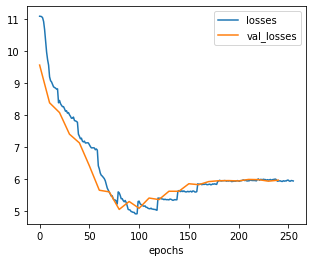

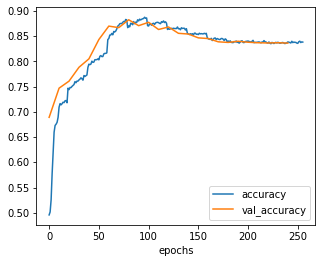

In [ ]:
plot_training(1, output, ['losses', 'val_losses'])
plot_training(1, output, ['accuracy', 'val_accuracy'])

In [ ]:
# discriminator pre-training

if training:
  teacher1 = Teacher(batch_size=512)

  syntax_trainer = syntax_training_dataset(teacher1, dataset_size=8192)

  network = SyntaxDiscriminator(vocab_size=syntax_trainer.teacher.vocab_size, embedding=True, 
                                embedding_dims=4)

  validation_dataset = syntax_training_dataset(teacher1, dataset_size=8192)

  output = pretrain_disc(300, 
                         network,
                         syntax_trainer, 
                         validation_dataset=validation_dataset,
                         loss_fn=nn.BCEWithLogitsLoss,
                         scheduler_patience=0,
                         data_augmentation_std=0.1,
                         evaluation_frequency=10,
                         dataset_update_rate=8,
                         num_workers=1,
                         seed=None,
                         optimizer_kwargs={'lr': 0.003, 
                                           'betas': (0.9, 0.999), 
                                           'eps': 1e-08, 
                                           'weight_decay': 0.0}, 
                         save_name='disc1')


trues created: 308, falses created: 716
trues created: 661, falses created: 1387
trues created: 1000, falses created: 2072
trues created: 1317, falses created: 2779
trues created: 1657, falses created: 3463
trues created: 4096, falses created: 4096
trues created: 318, falses created: 706
trues created: 638, falses created: 1410
trues created: 973, falses created: 2099
trues created: 1274, falses created: 2822
trues created: 1617, falses created: 3503
trues created: 4096, falses created: 4096
Starting training ...
===== Training loss for epoch 1:  0.00135409 =====
Accuracy:  0.4999
Saving best model
===== Training loss for epoch 2:  0.00135379 =====
Accuracy:  0.5000
Saving best model
===== Training loss for epoch 3:  0.00135387 =====
Accuracy:  0.4923
===== Training loss for epoch 4:  0.00135388 =====
Accuracy:  0.4885
===== Training loss for epoch 5:  0.00135378 =====
Accuracy:  0.5054
Saving best model
===== Training loss for epoch 6:  0.00135377 =====
Accuracy:  0.5051
===== Trainin

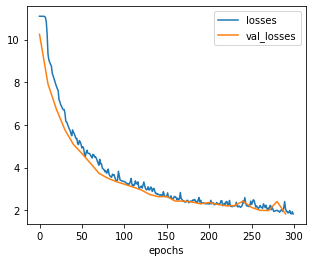

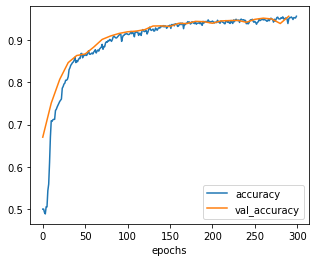

In [ ]:
plot_training(1, output, ['losses', 'val_losses'])
plot_training(1, output, ['accuracy', 'val_accuracy'])

In [ ]:
# discriminator pre-training

if training:
  teacher1 = Teacher(batch_size=512)

  syntax_trainer = syntax_training_dataset(teacher1, dataset_size=8192)

  network = SyntaxDiscriminator(vocab_size=syntax_trainer.teacher.vocab_size, embedding=True, 
                                embedding_dims=4)

  validation_dataset = syntax_training_dataset(teacher1, dataset_size=8192)

  output = pretrain_disc(256, 
                        network,
                        syntax_trainer, 
                        validation_dataset=validation_dataset,
                        loss_fn=nn.BCEWithLogitsLoss,
                        pos_weight=[0.95],
                        scheduler_patience=10,
                        data_augmentation_std=0.1,
                        dataset_update_rate=20,
                        num_workers=0,
                        seed=None,
                        optimizer_kwargs={'lr': 0.002, 
                                          'betas': (0.9, 0.999), 
                                          'eps': 1e-08, 
                                          'weight_decay': 0.0}, 
                        save_name='disc2')


trues created: 256, falses created: 768
trues created: 492, falses created: 1556
trues created: 761, falses created: 2311
trues created: 1024, falses created: 3072
trues created: 1283, falses created: 3837
trues created: 4096, falses created: 4096
trues created: 246, falses created: 778
trues created: 520, falses created: 1528
trues created: 773, falses created: 2299
trues created: 1038, falses created: 3058
trues created: 1297, falses created: 3823
trues created: 4096, falses created: 4096
Starting training ...
===== Training loss for epoch 1:  0.65775696 =====
Accuracy:  0.4993
Saving best model
===== Training loss for epoch 2:  0.65704204 =====
Accuracy:  0.5000
Saving best model
===== Training loss for epoch 3:  0.65661501 =====
Accuracy:  0.5000
===== Training loss for epoch 4:  0.65634475 =====
Accuracy:  0.5000
===== Training loss for epoch 5:  0.65464375 =====
Accuracy:  0.5002
Saving best model
===== Training loss for epoch 6:  0.64995637 =====
Accuracy:  0.5150
Saving best mo

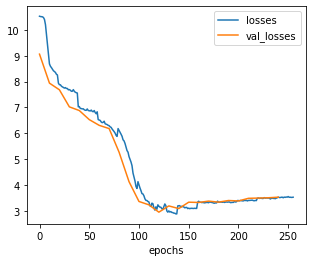

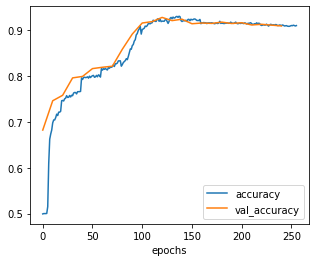

In [ ]:
plot_training(1, output, ['losses', 'val_losses'])
plot_training(1, output, ['accuracy', 'val_accuracy'])

In [ ]:
# discriminator pre-training

if training:
  teacher1 = Teacher(batch_size=512)

  syntax_trainer = syntax_training_dataset(teacher1, dataset_size=8192)

  network = SyntaxDiscriminator(vocab_size=syntax_trainer.teacher.vocab_size, 
                                embedding=True, 
                                embedding_dims=8, 
                                out_channels=(8, 8, 12, 16), 
                                kernels=(3, 3, 3, 3), 
                                dilations=(1, 1, 2, 3),
                                padding=(1, 0, 0, 0), 
                                dropout=0.2,
                                dense_dim=64)

  validation_dataset = syntax_training_dataset(teacher1, dataset_size=8192)

  output = pretrain_disc(256, 
                        network,
                        syntax_trainer, 
                        validation_dataset=validation_dataset,
                        loss_fn=nn.BCEWithLogitsLoss,
                        pos_weight=[0.95],
                        scheduler_patience=10,
                        data_augmentation_std=0.1,
                        evaluation_frequency=16,
                        dataset_update_rate=20,
                        num_workers=0,
                        seed=None,
                        optimizer_kwargs={'lr': 0.002, 
                                          'betas': (0.9, 0.999), 
                                          'eps': 1e-08, 
                                          'weight_decay': 0.0}, 
                        save_name='disc2')


trues created: 249, falses created: 775
trues created: 525, falses created: 1523
trues created: 794, falses created: 2278
trues created: 1050, falses created: 3046
trues created: 1300, falses created: 3820
trues created: 4096, falses created: 4096
trues created: 259, falses created: 765
trues created: 542, falses created: 1506
trues created: 805, falses created: 2267
trues created: 1070, falses created: 3026
trues created: 1316, falses created: 3804
trues created: 4096, falses created: 4096
Starting training ...
===== Training loss for epoch 1:  0.67561401 =====
Accuracy:  0.5001
Saving best model
===== Training loss for epoch 2:  0.67549427 =====
Accuracy:  0.5000
===== Training loss for epoch 3:  0.67553482 =====
Accuracy:  0.5000
===== Training loss for epoch 4:  0.67534161 =====
Accuracy:  0.5000
===== Training loss for epoch 5:  0.67413251 =====
Accuracy:  0.5006
Saving best model
===== Training loss for epoch 6:  0.66303145 =====
Accuracy:  0.5343
Saving best model
===== Training

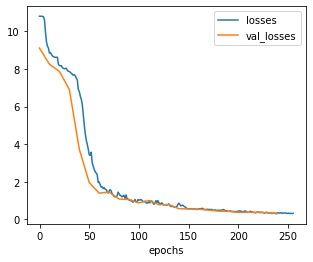

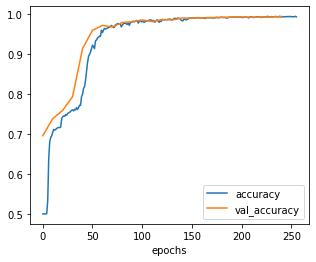

In [ ]:
plot_training(1, output, ['losses', 'val_losses'])
plot_training(1, output, ['accuracy', 'val_accuracy'])

## Train VAE just for sequence reconstruction

In [ ]:
# VAE training

if training:
  teacher2 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher2.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=False, 
                        double_decoder=False)

  self_reflector = QuestionGenSelfReflection(teacher2, 
                                             syntax_loss=False, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 30), 
                                             new_q_delay=140, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=100, 
                                             training_control=0.1)
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=None, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[1, 1, 1, 1, 1])


  output = train_recon(200, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=4,
                       evaluation_frequency=4,
                       num_workers=1,
                       method_output_layer_num=None,
                       discriminator=None,
                       disc_criterion=nn.BCEWithLogitsLoss,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name=None, 
                       save_metric='overall')


Starting training ...
===== Training loss for epoch 4:  0.00447792 =====
Reconstruction loss:  0.00309431
KLD loss:  0.00002981
Mean reconstruction accuracy: 0.06500244140625
Syntax accuracy for epoch 4: [0, 0, 0, 0, 0.1474609375]
===== Training loss for epoch 8:  0.00446380 =====
Reconstruction loss:  0.00309305
KLD loss:  0.00001695
Mean reconstruction accuracy: 0.04656982421875
Syntax accuracy for epoch 8: [0, 0, 0, 0.1474609375, 0.1240234375]
===== Training loss for epoch 12:  0.00445573 =====
Reconstruction loss:  0.00309140
KLD loss:  0.00001052
Mean reconstruction accuracy: 0.05145263671875
Syntax accuracy for epoch 12: [0, 0, 0.1474609375, 0.1240234375, 0.1103515625]
===== Training loss for epoch 16:  0.00444994 =====
Reconstruction loss:  0.00308925
KLD loss:  0.00000690
Mean reconstruction accuracy: 0.0574951171875
Syntax accuracy for epoch 16: [0, 0.1474609375, 0.1240234375, 0.1103515625, 0.0712890625]
===== Training loss for epoch 20:  0.00444543 =====
Reconstruction loss: 

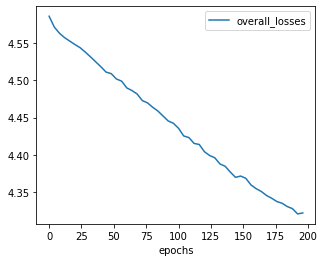

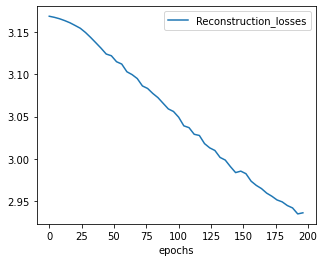

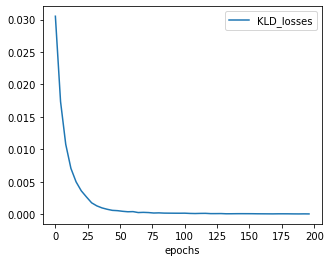

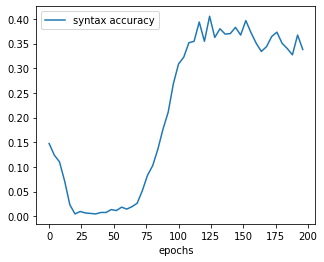

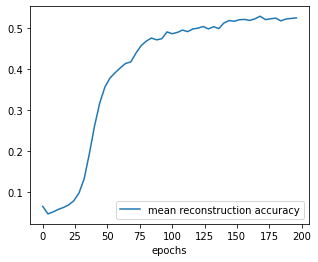

In [ ]:
plot_training(4, output, ['overall_losses'])
plot_training(4, output, ['Reconstruction_losses'])
plot_training(4, output, ['KLD_losses'])
plot_training(4, output, ['syntax accuracy'])
plot_training(4, output, ['mean reconstruction accuracy'])

## Train VAE with syntax discriminator

In [ ]:
# VAE with syntax discriminator training

if training:
  teacher3 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher3.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=False, 
                        double_decoder=False, 
                        method_vocab_size=teacher3.methods_size)

  self_reflector = QuestionGenSelfReflection(teacher3, 
                                             syntax_loss=True, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 64), 
                                             new_q_delay=196, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=100, 
                                             training_control=0.1)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher3.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[1, 1, 1, 1, 1])


  output = train_recon(256, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=8,
                       evaluation_frequency=8,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_syntax_1', 
                       save_metric='overall')



Starting training ...
===== Training loss for epoch 8:  0.00526193 =====
Reconstruction loss:  0.00309112
KLD loss:  0.00001968
Syntax loss:  0.00012043
Mean reconstruction accuracy: 0.08526611328125
Syntax accuracy for epoch 8: [0, 0, 0, 0, 0.0]
Saving best model
===== Training loss for epoch 16:  0.00523062 =====
Reconstruction loss:  0.00309036
KLD loss:  0.00000802
Syntax loss:  0.00010154
Mean reconstruction accuracy: 0.0679931640625
Syntax accuracy for epoch 16: [0, 0, 0, 0.0, 0.0]
Saving best model
===== Training loss for epoch 24:  0.00520335 =====
Reconstruction loss:  0.00309081
KLD loss:  0.00000450
Syntax loss:  0.00007733
Mean reconstruction accuracy: 0.08673095703125
Syntax accuracy for epoch 24: [0, 0, 0.0, 0.0, 0.0]
Saving best model
===== Training loss for epoch 32:  0.00518398 =====
Reconstruction loss:  0.00309058
KLD loss:  0.00000313
Syntax loss:  0.00005956
Mean reconstruction accuracy: 0.0899658203125
Syntax accuracy for epoch 32: [0, 0.0, 0.0, 0.0, 0.00390625]
S

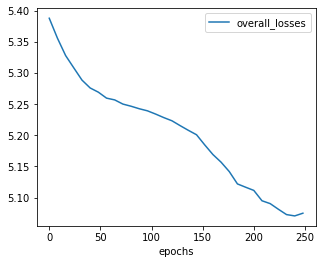

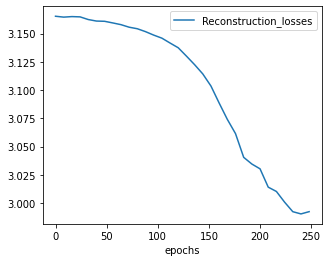

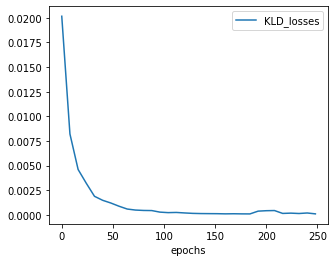

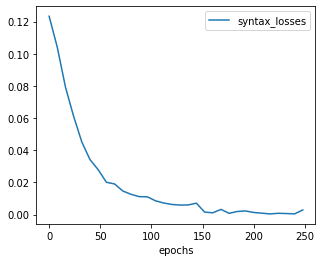

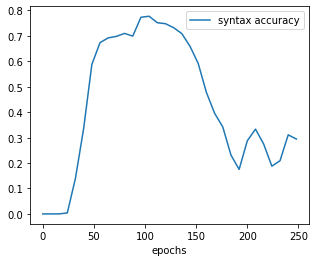

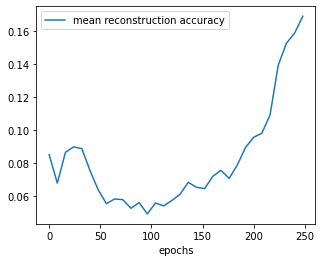

In [ ]:
plot_training(8, output, ['overall_losses'])
plot_training(8, output, ['Reconstruction_losses'])
plot_training(8, output, ['KLD_losses'])
plot_training(8, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(8, output, ['syntax accuracy'])
plot_training(8, output, ['mean reconstruction accuracy'])


In [ ]:
# VAE with syntax discriminator training

if training:
  teacher3 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher3.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=False, 
                        double_decoder=False, 
                        method_vocab_size=teacher3.methods_size)

  self_reflector = QuestionGenSelfReflection(teacher3, 
                                             syntax_loss=True, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 64), 
                                             new_q_delay=196, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.01)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher3.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 1, 1])


  output = train_recon(1024, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_syntax_1', 
                       save_metric='overall')



Starting training ...
===== Training loss for epoch 32:  0.00523905 =====
Reconstruction loss:  0.00309376
KLD loss:  0.00001681
Syntax loss:  0.00009777
Mean reconstruction accuracy: 0.39715576171875
Syntax accuracy for epoch 32: [0, 0, 0, 0, 0.046875]
Saving best model
===== Training loss for epoch 64:  0.00513945 =====
Reconstruction loss:  0.00308251
KLD loss:  0.00000568
Syntax loss:  0.00002055
Mean reconstruction accuracy: 0.34027099609375
Syntax accuracy for epoch 64: [0, 0, 0, 0.046875, 0.146484375]
Saving best model
===== Training loss for epoch 96:  0.00509007 =====
Reconstruction loss:  0.00305425
KLD loss:  0.00000208
Syntax loss:  0.00000304
Mean reconstruction accuracy: 0.33538818359375
Syntax accuracy for epoch 96: [0, 0, 0.046875, 0.146484375, 0.2275390625]
Saving best model
===== Training loss for epoch 128:  0.00504814 =====
Reconstruction loss:  0.00301447
KLD loss:  0.00000095
Syntax loss:  0.00000201
Mean reconstruction accuracy: 0.415771484375
Syntax accuracy for

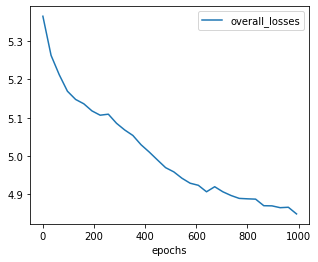

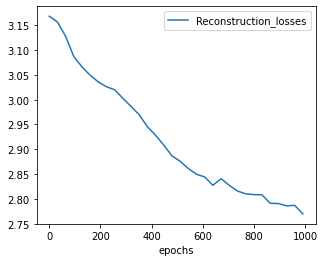

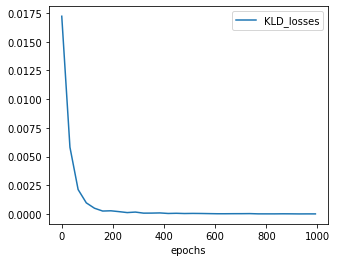

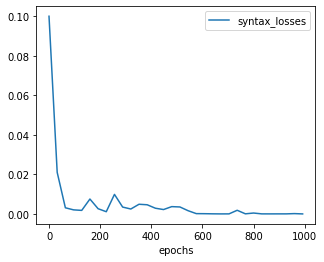

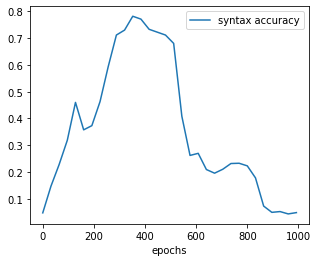

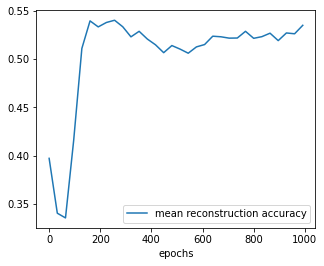

In [ ]:
plot_training(32, output, ['overall_losses'])
plot_training(32, output, ['Reconstruction_losses'])
plot_training(32, output, ['KLD_losses'])
plot_training(32, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(32, output, ['syntax accuracy'])
plot_training(32, output, ['mean reconstruction accuracy'])

In [ ]:
# VAE with syntax discriminator training

if training:
  teacher3 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher3.vocab_size, 
                        embedding_dim=8, 
                        out_channels=(8, 8, 12, 16), 
                        kernels=(3, 3, 3, 3), 
                        dilations=(1, 1, 2, 3),
                        padding=(1, 0, 0, 0),
                        weightnorm=True, 
                        dropout=0.2, 
                        skip=False, 
                        method_branch=False, 
                        double_decoder=False, 
                        method_vocab_size=teacher3.methods_size, 
                        method_input_dim=(16, 4), 
                        method_hidden_lengths=(64, ))

  self_reflector = QuestionGenSelfReflection(teacher3, 
                                             syntax_loss=True, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 128), 
                                             new_q_delay=256, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.01)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher3.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 1, 1])


  output = train_recon(512, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 0.002, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_syntax_2', 
                       save_metric='overall')



Starting training ...
===== Training loss for epoch 32:  0.00512317 =====
Reconstruction loss:  0.00308128
KLD loss:  0.00000009
Syntax loss:  0.00001110
Mean reconstruction accuracy: 0.18243408203125
Syntax accuracy for epoch 32: [0, 0, 0, 0, 0.400390625]
Saving best model
===== Training loss for epoch 64:  0.00508154 =====
Reconstruction loss:  0.00304531
KLD loss:  0.00000000
Syntax loss:  0.00000552
Mean reconstruction accuracy: 0.251953125
Syntax accuracy for epoch 64: [0, 0, 0, 0.400390625, 0.560546875]
Saving best model
===== Training loss for epoch 96:  0.00504521 =====
Reconstruction loss:  0.00301051
KLD loss:  0.00000000
Syntax loss:  0.00000399
Mean reconstruction accuracy: 0.2655029296875
Syntax accuracy for epoch 96: [0, 0, 0.400390625, 0.560546875, 0.6416015625]
Saving best model
===== Training loss for epoch 128:  0.00493812 =====
Reconstruction loss:  0.00290476
KLD loss:  0.00000000
Syntax loss:  0.00000265
Mean reconstruction accuracy: 0.26409912109375
Syntax accurac

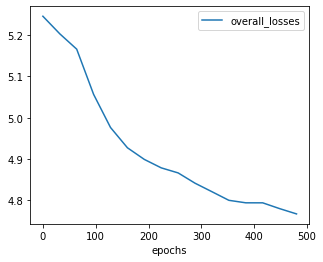

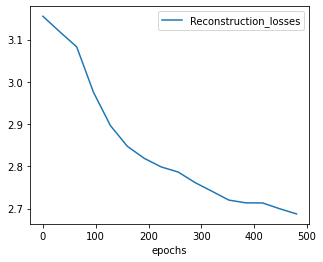

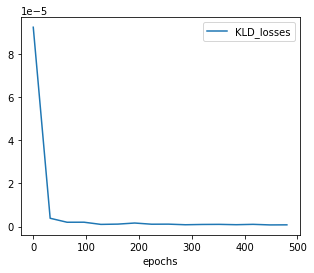

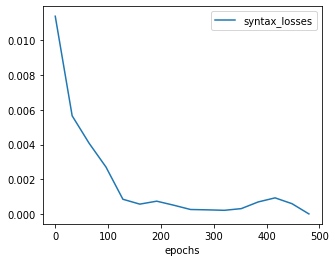

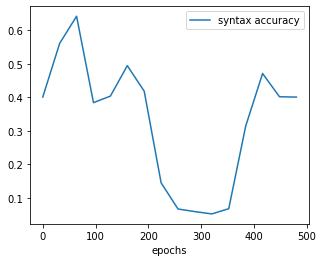

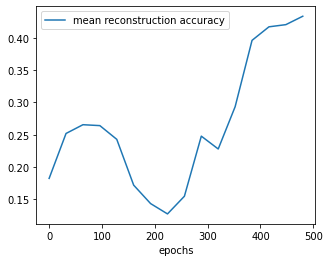

In [ ]:
plot_training(32, output, ['overall_losses'])
plot_training(32, output, ['Reconstruction_losses'])
plot_training(32, output, ['KLD_losses'])
plot_training(32, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(32, output, ['syntax accuracy'])
plot_training(32, output, ['mean reconstruction accuracy'])

In [ ]:
# VAE with syntax discriminator training

if training:
  teacher3 = Teacher(batch_size=8192)

  network = QuestionVAE(vocab_size=teacher3.vocab_size, 
                        embedding_dim=8, 
                        out_channels=(8, 8, 12, 16), 
                        kernels=(3, 3, 3, 3), 
                        dilations=(1, 1, 2, 3),
                        padding=(1, 0, 0, 0),
                        weightnorm=True, 
                        dropout=0.2, 
                        skip=True, 
                        method_branch=False, 
                        double_decoder=True, 
                        method_vocab_size=teacher3.methods_size, 
                        method_input_dim=(16, 4), 
                        method_hidden_lengths=(64, ))

  self_reflector = QuestionGenSelfReflection(teacher3, 
                                             syntax_loss=True, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 129), 
                                             new_q_delay=256, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.01)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher3.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 1, 1])


  output = train_recon(512, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 0.006, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_syntax_3', 
                       save_metric='overall')



Starting training ...
===== Training loss for epoch 32:  0.00238372 =====
Reconstruction loss:  0.00038728
KLD loss:  0.00174092
Syntax loss:  0.00000169
Mean reconstruction accuracy: 0.02957916259765625
Syntax accuracy for epoch 32: [0, 0, 0, 0, 0.369384765625]
Saving best model
===== Training loss for epoch 64:  0.00132019 =====
Reconstruction loss:  0.00038470
KLD loss:  0.00068088
Syntax loss:  0.00000077
Mean reconstruction accuracy: 0.1402435302734375
Syntax accuracy for epoch 64: [0, 0, 0, 0.369384765625, 0.5091552734375]
Saving best model
===== Training loss for epoch 96:  0.00099835 =====
Reconstruction loss:  0.00035997
KLD loss:  0.00038414
Syntax loss:  0.00000040
Mean reconstruction accuracy: 0.33675384521484375
Syntax accuracy for epoch 96: [0, 0, 0.369384765625, 0.5091552734375, 0.521240234375]
Saving best model
===== Training loss for epoch 128:  0.00085384 =====
Reconstruction loss:  0.00034307
KLD loss:  0.00025676
Syntax loss:  0.00000016
Mean reconstruction accuracy

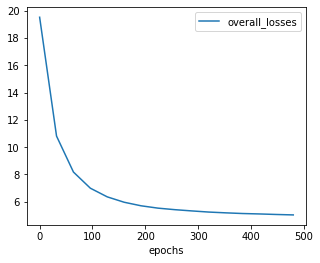

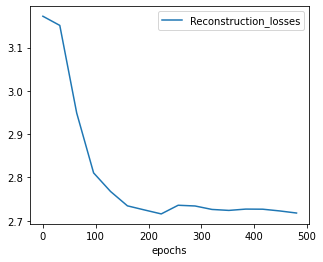

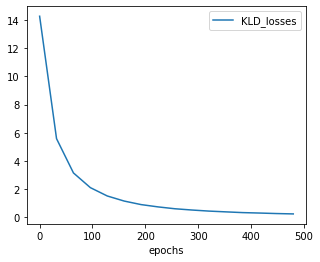

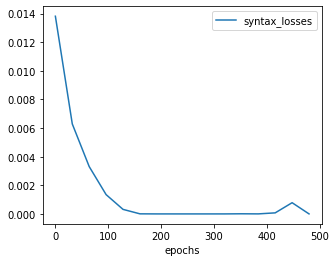

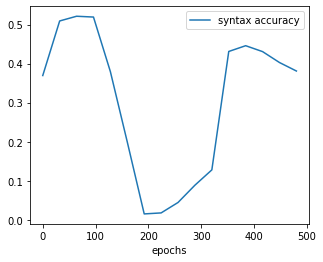

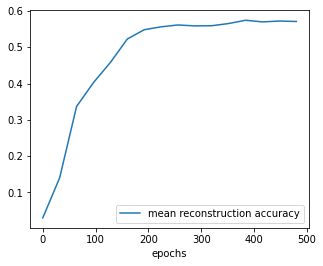

In [ ]:
plot_training(32, output, ['overall_losses'])
plot_training(32, output, ['Reconstruction_losses'])
plot_training(32, output, ['KLD_losses'])
plot_training(32, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(32, output, ['syntax accuracy'])
plot_training(32, output, ['mean reconstruction accuracy'])

## Add in method branch to VAE

In [ ]:
# first without syntax loss

if training:
  teacher4 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher4.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=True, 
                        double_decoder=False, 
                        method_vocab_size=teacher4.methods_size)

  self_reflector = QuestionGenSelfReflection(teacher4, 
                                             syntax_loss=False, 
                                             model_methods=True,
                                             new_qs_per_n_epochs=(1, 64), 
                                             new_q_delay=196, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=1000, 
                                             training_control=0.1)
  
  # discriminator = SyntaxDiscriminator(vocab_size=teacher4.vocab_size, embedding=True, 
  #                                     embedding_dims=4)
  # discriminator = load_state(discriminator, 'disc1', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=None, 
                          method_recon=nn.BCEWithLogitsLoss, 
                          method_target=nn.BCEWithLogitsLoss, 
                          weights_init=None, 
                          manual_weights=[1, 1, 1, 1, 1])


  output = train_recon(512, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=8,
                       evaluation_frequency=8,
                       num_workers=0,
                       discriminator=None,
                       disc_criterion=nn.BCEWithLogitsLoss,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_methods_1', 
                       save_metric='overall')


Starting training ...
===== Training loss for epoch 8:  0.00718472 =====
Reconstruction loss:  0.00309227
KLD loss:  0.00001619
Method reconstruction loss:  0.00068094
Method output vs reconstruction method loss:  0.00068772
Mean reconstruction accuracy: 0.0438232421875
Mean top method reconstruction accuracy: 0.2939453125
Syntax accuracy for epoch 8: [0, 0, 0, 0, 0.3974609375]
Saving best model
===== Training loss for epoch 16:  0.00716081 =====
Reconstruction loss:  0.00308930
KLD loss:  0.00000724
Method reconstruction loss:  0.00067613
Method output vs reconstruction method loss:  0.00068053
Mean reconstruction accuracy: 0.04241943359375
Mean top method reconstruction accuracy: 0.298828125
Syntax accuracy for epoch 16: [0, 0, 0, 0.3974609375, 0.20703125]
Saving best model
===== Training loss for epoch 24:  0.00714968 =====
Reconstruction loss:  0.00308484
KLD loss:  0.00000388
Method reconstruction loss:  0.00067637
Method output vs reconstruction method loss:  0.00067697
Mean reco

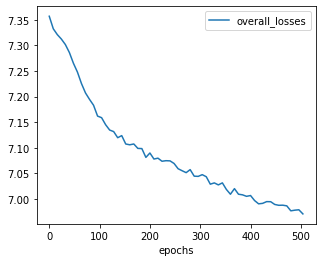

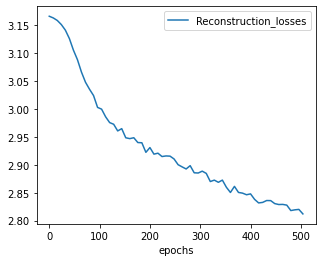

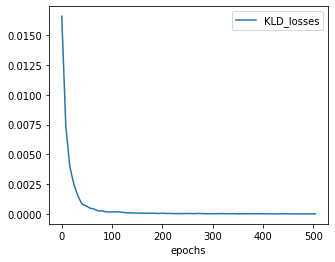

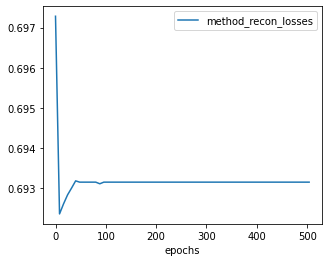

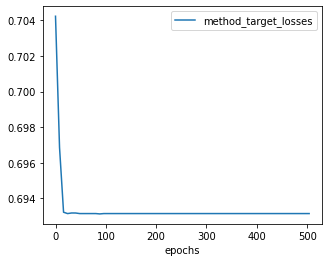

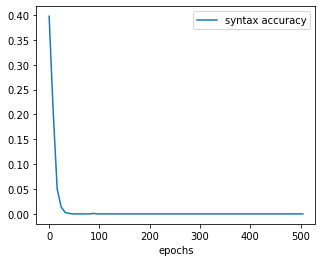

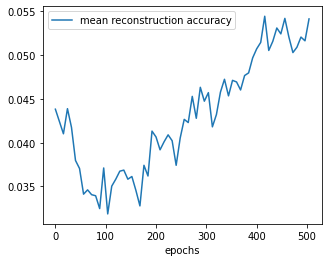

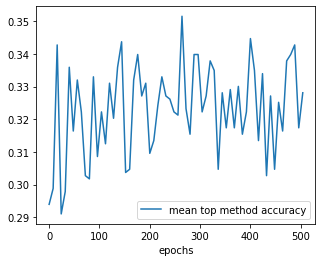

In [ ]:
plot_training(8, output, ['overall_losses'])
plot_training(8, output, ['Reconstruction_losses'])
plot_training(8, output, ['KLD_losses'])
plot_training(8, output, ['method_recon_losses'])
plot_training(8, output, ['method_target_losses'])
# plot_training(8, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(8, output, ['syntax accuracy'])
plot_training(8, output, ['mean reconstruction accuracy'])
plot_training(8, output, ['mean top method accuracy'])



In [ ]:
# now with syntax loss

if training:
  teacher4 = Teacher(batch_size=1024)

  network = QuestionVAE(vocab_size=teacher4.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=True, 
                        double_decoder=False, 
                        method_vocab_size=teacher4.methods_size)

  self_reflector = QuestionGenSelfReflection(teacher4, 
                                             syntax_loss=True, 
                                             model_methods=True,
                                             new_qs_per_n_epochs=(1, 64), 
                                             new_q_delay=196, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=1000, 
                                             training_control=0.1)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher4.vocab_size, embedding=True, 
                                      embedding_dims=4)
  discriminator = load_state(discriminator, 'disc1', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=nn.BCEWithLogitsLoss, 
                          method_target=nn.BCEWithLogitsLoss, 
                          weights_init=None, 
                          manual_weights=[1, 1, 1, 1, 1])


  output = train_recon(256, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=8,
                       evaluation_frequency=8,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_methods_2', 
                       save_metric='overall')


Starting training ...
===== Training loss for epoch 8:  0.00842301 =====
Reconstruction loss:  0.00309456
KLD loss:  0.00008606
Syntax loss:  0.00050408
Method reconstruction loss:  0.00067690
Method output vs reconstruction method loss:  0.00067690
Mean reconstruction accuracy: 0.03350830078125
Mean top method reconstruction accuracy: 0.134765625
Syntax accuracy for epoch 8: [0, 0, 0, 0, 0.0]
Saving best model
===== Training loss for epoch 16:  0.00794727 =====
Reconstruction loss:  0.00309358
KLD loss:  0.00003899
Syntax loss:  0.00007640
Method reconstruction loss:  0.00067690
Method output vs reconstruction method loss:  0.00067690
Mean reconstruction accuracy: 0.0335693359375
Mean top method reconstruction accuracy: 0.1484375
Syntax accuracy for epoch 16: [0, 0, 0, 0.0, 0.0]
Saving best model
===== Training loss for epoch 24:  0.00786942 =====
Reconstruction loss:  0.00309318
KLD loss:  0.00001868
Syntax loss:  0.00001925
Method reconstruction loss:  0.00067690
Method output vs re

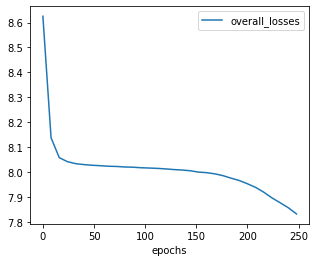

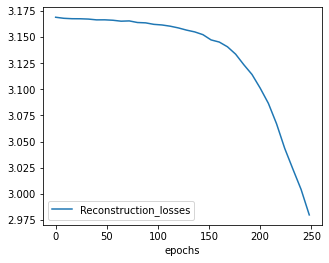

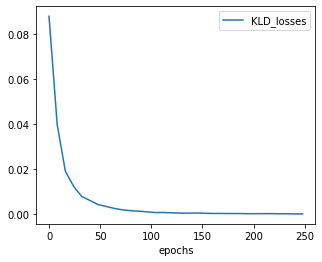

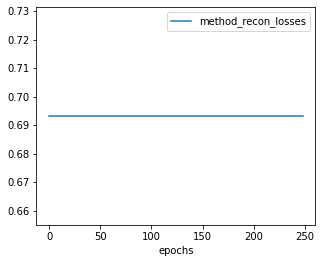

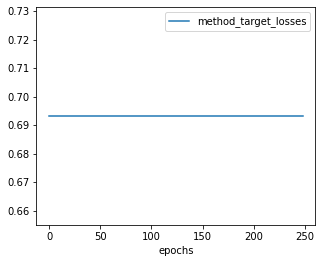

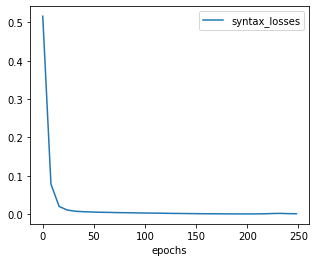

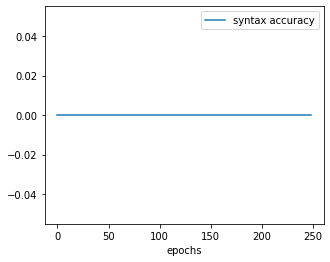

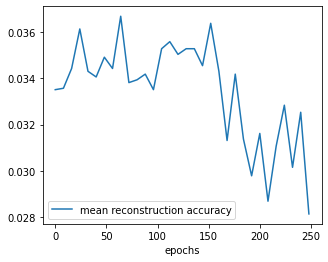

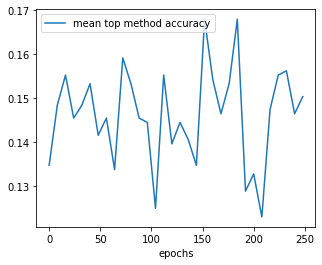

In [ ]:
plot_training(8, output, ['overall_losses'])
plot_training(8, output, ['Reconstruction_losses'])
plot_training(8, output, ['KLD_losses'])
plot_training(8, output, ['method_recon_losses'])
plot_training(8, output, ['method_target_losses'])
plot_training(8, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(8, output, ['syntax accuracy'])
plot_training(8, output, ['mean reconstruction accuracy'])
plot_training(8, output, ['mean top method accuracy'])


In [ ]:
# now with syntax loss

if training:
  teacher4 = Teacher(batch_size=9)

  network = QuestionVAE(vocab_size=teacher4.vocab_size, 
                        embedding_dim=4, 
                        weightnorm=True, 
                        dropout=0.1, 
                        skip=False, 
                        method_branch=True, 
                        double_decoder=False, 
                        method_vocab_size=teacher4.methods_size)

  self_reflector = QuestionGenSelfReflection(teacher4, 
                                             syntax_loss=True, 
                                             model_methods=True,
                                             new_qs_per_n_epochs=(1, 64), 
                                             new_q_delay=196, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=1000, 
                                             training_control=0.1)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher4.vocab_size, embedding=True, 
                                      embedding_dims=4)
  discriminator = load_state(discriminator, 'disc1', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=nn.BCEWithLogitsLoss, 
                          method_target=nn.BCEWithLogitsLoss, 
                          weights_init=None, 
                          manual_weights=[1, 1, 1, 1, 1])


  output = train_recon(11, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=4,
                       evaluation_frequency=4,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 1e-3, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='VAE_methods_2', 
                       save_metric='overall')


Starting training ...
syntax_output from discrim: tensor([-0.2877, -0.6538, -0.7801, -0.6142, -0.4489, -0.6964, -1.1394, -0.9669,
        -0.8793], device='cuda:0', grad_fn=<ViewBackward0>)
syntax_labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
syntax_out shape: torch.Size([9])
syntax_output from discrim: tensor([-0.3957, -0.3222, -0.4522,  0.1562, -0.2336, -0.5900, -0.3573,  0.4164,
        -0.6918], device='cuda:0', grad_fn=<ViewBackward0>)
syntax_labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
syntax_out shape: torch.Size([9])
syntax_output from discrim: tensor([-0.2855, -0.3647, -0.1158, -0.6196, -0.0396, -0.0755, -0.3757, -0.3258,
        -0.4048], device='cuda:0', grad_fn=<ViewBackward0>)
syntax_labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
syntax_out shape: torch.Size([9])
syntax_output from discrim: tensor([ 0.2798,  0.0646,  0.0853,  0.1590, -0.0161,  0.1408,  0.3389, -0.2008,
        -0.0985], device='cuda:0'

In [ ]:
# all together

if training:
  teacher5 = Teacher(batch_size=8192)

  network = QuestionVAE(vocab_size=teacher5.vocab_size, 
                        embedding_dim=8, 
                        out_channels=(8, 8, 12, 16), 
                        kernels=(3, 3, 3, 3), 
                        dilations=(1, 1, 2, 3),
                        padding=(1, 0, 0, 0),
                        weightnorm=True, 
                        dropout=0.2, 
                        skip=True, 
                        method_branch=False, 
                        double_decoder=True, 
                        method_vocab_size=teacher3.methods_size, 
                        method_input_dim=(16, 4), 
                        method_hidden_lengths=(64, ))

  self_reflector = QuestionGenSelfReflection(teacher5, 
                                             syntax_loss=True, 
                                             model_methods=False,
                                             new_qs_per_n_epochs=(1, 129), 
                                             new_q_delay=256, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.01)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher5.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=False,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=None, 
                          method_target=None, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 1, 1])


  output = train_recon(512, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 0.006, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='all_1', 
                       save_metric='overall')



## Investigate use of Trainable Loss Weights

In [ ]:
# with trainable loss

if training:
  teacher5 = Teacher(batch_size=8192)

  network = QuestionVAE(vocab_size=teacher5.vocab_size, 
                        embedding_dim=8, 
                        out_channels=(8, 8, 12, 16), 
                        kernels=(3, 3, 3, 3), 
                        dilations=(1, 1, 2, 3),
                        padding=(1, 0, 0, 0),
                        weightnorm=True, 
                        dropout=0.2, 
                        skip=True, 
                        method_branch=True, 
                        double_decoder=True, 
                        method_vocab_size=teacher3.methods_size, 
                        method_input_dim=(8, 4), 
                        method_hidden_lengths=(32, ))

  self_reflector = QuestionGenSelfReflection(teacher5, 
                                             syntax_loss=True, 
                                             model_methods=True,
                                             new_qs_per_n_epochs=(1, 129), 
                                             new_q_delay=513, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.001)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher5.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=True,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=nn.BCEWithLogitsLoss, 
                          method_target=nn.BCEWithLogitsLoss, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 0.01, 0.01], 
                          reg_factor_ind=0.01, 
                          reg_factor_sum=0.3)


  output = train_recon(512, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 0.006, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='all_1', 
                       save_metric='overall')



Starting training ...
===== Training loss for epoch 32:  0.00383967 =====
Reconstruction loss:  0.00036798
KLD loss:  0.00334984
Syntax loss:  0.00000038
Method reconstruction loss:  0.00007208
Method output vs reconstruction method loss:  0.00007426
Mean reconstruction accuracy: 0.0994415283203125
Mean top method reconstruction accuracy: 0.765380859375
Syntax accuracy for epoch 32: [0, 0, 0, 0, 0.63623046875]
Saving best model
===== Training loss for epoch 64:  0.00241671 =====
Reconstruction loss:  0.00034929
KLD loss:  0.00193022
Syntax loss:  0.00000019
Method reconstruction loss:  0.00008307
Method output vs reconstruction method loss:  0.00008402
Mean reconstruction accuracy: 0.2959442138671875
Mean top method reconstruction accuracy: 0.976318359375
Syntax accuracy for epoch 64: [0, 0, 0, 0.63623046875, 0.0496826171875]
Saving best model
===== Training loss for epoch 96:  0.00186928 =====
Reconstruction loss:  0.00033747
KLD loss:  0.00140869
Syntax loss:  0.00000020
Method recon

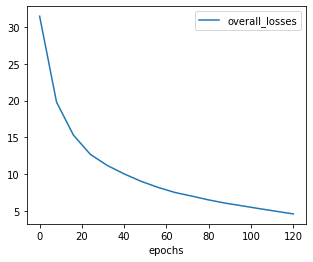

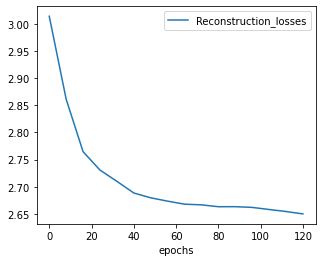

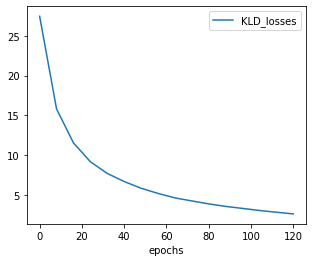

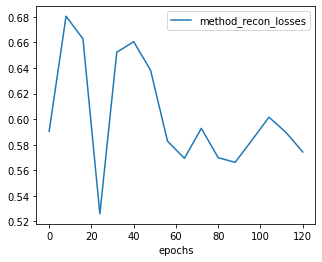

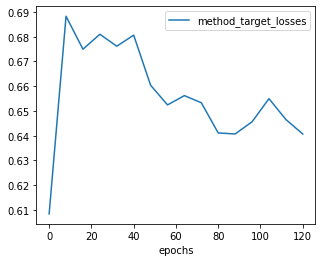

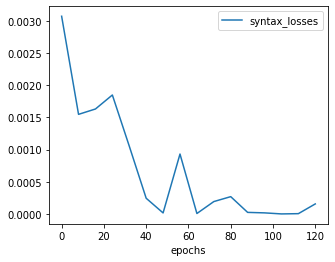

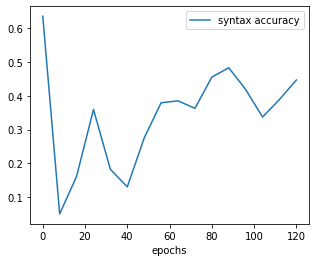

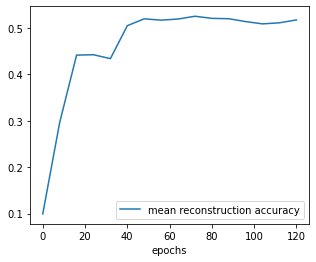

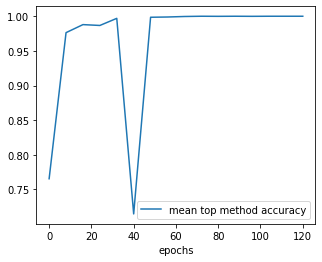

In [ ]:
plot_training(8, output, ['overall_losses'])
plot_training(8, output, ['Reconstruction_losses'])
plot_training(8, output, ['KLD_losses'])
plot_training(8, output, ['method_recon_losses'])
plot_training(8, output, ['method_target_losses'])
plot_training(8, output, ['syntax_losses'])
# plot_training(8, output, ['discriminator_losses'])

plot_training(8, output, ['syntax accuracy'])
plot_training(8, output, ['mean reconstruction accuracy'])
plot_training(8, output, ['mean top method accuracy'])


In [ ]:
# with trainable loss
training = False
if training:
  teacher5 = Teacher(batch_size=8192)

  network = QuestionVAE(vocab_size=teacher5.vocab_size, 
                        embedding_dim=8, 
                        out_channels=(12, 12, 12, 16), 
                        kernels=(3, 3, 3, 3), 
                        dilations=(1, 1, 2, 3),
                        padding=(1, 0, 0, 0),
                        weightnorm=True, 
                        dropout=0.2, 
                        skip=False, 
                        method_branch=True, 
                        double_decoder=True, 
                        method_vocab_size=teacher5.methods_size, 
                        method_input_dim=(8, 4), 
                        method_hidden_lengths=(32, ))

  self_reflector = QuestionGenSelfReflection(teacher5, 
                                             syntax_loss=True, 
                                             model_methods=True,
                                             new_qs_per_n_epochs=(1, 129), 
                                             new_q_delay=513, 
                                             metric_store_len=5, 
                                             q_recon_thresh=0.9,
                                             consolidation_weight=256, 
                                             training_control=0.001)
  
  discriminator = SyntaxDiscriminator(vocab_size=teacher5.vocab_size,
                                      embedding=True, 
                                      embedding_dims=8, 
                                      out_channels=(8, 8, 12, 16), 
                                      kernels=(3, 3, 3, 3), 
                                      dilations=(1, 1, 2, 3),
                                      padding=(1, 0, 0, 0), 
                                      dropout=0.2,
                                      dense_dim=64)
  
  discriminator = load_state(discriminator, 'disc2', model_type='discriminator')
  
  loss_fn = MultiTaskLoss(trainable=True,
                          recon=nn.CrossEntropyLoss, 
                          kld=kld_loss, 
                          syntax=nn.BCEWithLogitsLoss, 
                          method_recon=nn.BCEWithLogitsLoss, 
                          method_target=nn.BCEWithLogitsLoss, 
                          weights_init=None, 
                          manual_weights=[0.1, 4, 1, 0.01, 0.01], 
                          reg_factor_ind=0.01, 
                          reg_factor_sum=0.3)


  output = train_recon(256, 
                       network, 
                       self_reflector,
                       loss_fn,
                       scheduler_VAE_patience=None,
                       sr_update_rate=32,
                       evaluation_frequency=32,
                       num_workers=0,
                       discriminator=discriminator,
                       disc_criterion=None,
                       seed=None,
                       optimizer_VAE_kwargs={'lr': 0.006, 
                                             'betas': (0.9, 0.999), 
                                             'eps': 1e-08, 
                                             'weight_decay': 0.0}, 
                       optimizer_disc_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       optimizer_loss_kwargs={'lr': 1e-3, 
                                              'betas': (0.9, 0.999), 
                                              'eps': 1e-08, 
                                              'weight_decay': 0.0},                
                       save_name='all_2', 
                       save_metric='overall')



# Exploring the Latent Space

In [ ]:
# handle device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# get mu and log_var parameters for a give question type
mu = self_reflector.q_mus[('addition', 'n+n')]
log_var = self_reflector.q_log_vars[('addition', 'n+n')]
mu = torch.mean(torch.stack(mu), dim=0)
log_var = torch.mean(torch.stack(log_var), dim=0)

# generate outputs
samples, methods = network.generate(20,
                                    device, 
                                    mu=mu, 
                                    std=log_var)

# print outputs
int_outputs = torch.argmax(samples, dim=1)
for row in int_outputs:
  # get question in symbol form
  symbol_question = self_reflector.teacher.question_from_ix(row)
  print(symbol_question)